# ENCODE Long Read Sequel2 dataset

This tutorial guides through a typical Long Read Transcriptome Sequencing (LRTS) analysis workflow with isotools, 
using ENCODE Isoseq Sequel2 Data. It demonstrates the analysis of alternative splicing events within and between sample groups. 

## Preparation
Select the "long read RNA-seq" samples in the ENCODE data portal (https://www.encodeproject.org/) and download aligned .bam files. Here I use all Sequel II samples available at the time of writing, but you choose to process a subset.
Download the files with curl and use samtools to index the bam files.
``` sh
xargs -L 1 curl -O -J -L < ENCODE_files.txt
for bam in *bam; 
    do samtools index $bam
done
```
In addition to the bamfiles, a file metadata.tsv should have been downloaded, which we use to read the sample information. Further you need a reference annotation and a genome fastq file. Please see the Alzheimer tutorial how to get these files. 

## Data import

In [1]:
from  isotools import Transcriptome
from isotools import __version__ as isotools_version
print(f'This is isootools version {isotools_version}')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from collections import Counter

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')


This is isootools version 0.1.3_dev


In [2]:
#I assume the encode data (e.g. the bam files) are in an subdirctory "encode"

#first, process the metadata
metadata_link="https://www.encodeproject.org/metadata/?type=Experiment&assay_title=long+read+RNA-seq&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&files.file_type=bam&files.file_type=fastq&advancedQuery=date_released%3A%5B2009-02-01+TO+2021-12-31%5D&searchTerm=long+read+RNA-seq"
metadata=pd.read_csv(metadata_link, sep='\t')
platform=metadata.set_index('Experiment accession').Platform.dropna().to_dict()
for pf,count in Counter(platform.values()).items():
    print(f'{pf}: {count} samples from ENCODE')

#Select the samples from the metadata, make sure there are only bam files are in the table
samples=metadata[(metadata['Output type']=='alignments') & (metadata['File Status']=='released')].copy()
samples['Platform']=[platform.get(ea,'unknown') for ea in samples['Experiment accession']] #This info is missing for some files
samples=samples[['File accession','Output type','Biosample term name','Biosample type','Technical replicate(s)','Platform']].reset_index(drop=True) 
#we select all all SequelII files - adjust this as needed
samples=samples[samples.Platform=='Pacific Biosciences Sequel II'].reset_index(drop=True) 

#additional infos about the samples
infos=pd.read_csv('encode_samples.tsv', sep='\t').set_index('sample term')


chrom=[f'chr{i+1}'for i in range(22)]+['chrX','chrY']
#ENCODE uses an interesting reference, including sequences from viruses
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'

#check that all selected files have been downloaded and indexed, and that they can be found in the right folder
notfound=[]
for accession in samples['File accession']:
    if not os.path.isfile(f"encode/{accession}.bam"):
        logger.warning(f'bam file not found for {accession}')
    elif not os.path.isfile(f"encode/{accession}.bam"):
        logger.warning(f'bam index not found for {accession}')
    else:
        continue
    notfound.append(accession)
        
#print the sample table
samples

Pacific Biosciences Sequel: 16 samples from ENCODE
Pacific Biosciences Sequel II: 41 samples from ENCODE
Oxford Nanopore MinION: 5 samples from ENCODE


File accession Output type                    Biosample term name  \
0     ENCFF925MYC  alignments                              osteocyte   
1     ENCFF558QPF  alignments                              osteocyte   
2     ENCFF973OML  alignments                 type B pancreatic cell   
3     ENCFF058HQU  alignments                 type B pancreatic cell   
4     ENCFF779VVX  alignments                lower lobe of left lung   
5     ENCFF319JFG  alignments                      neural crest cell   
6     ENCFF901XCR  alignments                      neural crest cell   
7     ENCFF219UJG  alignments                                GM12878   
8     ENCFF118JEI  alignments                                  MCF-7   
9     ENCFF660UTF  alignments                  heart right ventricle   
10    ENCFF018PZX  alignments                  heart right ventricle   
11    ENCFF291EKY  alignments                   right cardiac atrium   
12    ENCFF810FRP  alignments                                  HL-60   
13    ENCFF600MGT  alignments                                  HL-60   
14    ENCFF509GHY  alignments  progenitor cell of endocrine pancreas   
15    ENCFF803KIA  alignments  progenitor cell of endocrine pancreas   
16    ENCFF745HHL  alignments                                  aorta   
17    ENCFF971JDY  alignments                     mesenteric fat pad   
18    ENCFF661OEY  alignments                                   K562   
19    ENCFF645UVN  alignments                                   K562   
20    ENCFF924HBV  alignments                lower lobe of left lung   
21    ENCFF044LIA  alignments                                   PC-3   
22    ENCFF322UJU  alignments                                   K562   
23    ENCFF613SDS  alignments                   right cardiac atrium   
24    ENCFF840OVC  alignments    Right ventricle myocardium superior   
25    ENCFF545PJV  alignments                                 IMR-90   
26    ENCFF814ABW  alignments                                  HepG2   
27    ENCFF400LRT  alignments                                 HCT116   
28    ENCFF984RMR  alignments                                  ovary   
29    ENCFF745DHX  alignments                                  Panc1   
30    ENCFF502LAB  alignments                   heart left ventricle   
31    ENCFF936VUF  alignments                        endodermal cell   
32    ENCFF939EUU  alignments                        endodermal cell   
33    ENCFF472TSL  alignments                    posterior vena cava   
34    ENCFF239CWJ  alignments                                 kidney   
35    ENCFF292UIE  alignments                                     H9   
36    ENCFF738RAA  alignments                                     H9   
37    ENCFF911RNV  alignments                   right cardiac atrium   
38    ENCFF583MSU  alignments                                  ovary   
39    ENCFF648NAR  alignments                                GM12878   
40    ENCFF225CCJ  alignments                                GM12878   
41    ENCFF623IBV  alignments                   heart left ventricle   
42    ENCFF193WEX  alignments                           psoas muscle   
43    ENCFF173JOL  alignments    Right ventricle myocardium inferior   
44    ENCFF132YCF  alignments     left ventricle myocardium inferior   
45    ENCFF850YMO  alignments     left ventricle myocardium superior   
46    ENCFF305AFY  alignments                  heart right ventricle   
47    ENCFF437SYY  alignments                   heart left ventricle   

                   Biosample type Technical replicate(s)  \
0   in vitro differentiated cells                    1_1   
1   in vitro differentiated cells                    2_1   
2   in vitro differentiated cells                    2_1   
3   in vitro differentiated cells                    1_1   
4                          tissue                    1_1   
5   in vitro differentiated cells                    1_1   
6   in vitro differentiated cells                    2

In [3]:
cols_of_interest=['cell', 'lineage', 'organ', 'karyotype']
try:    
    isoseq=Transcriptome(f'encode/encode_isotools.pkl')
except FileNotFoundError:
    try:
        isoseq=Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        isoseq=Transcriptome.from_reference(anno+'.gff3.gz')
        isoseq.save_reference(anno+'.isotools.pkl')
    for i,row in samples.iterrows():
        if row['File accession'] in notfound:
            continue
            
        sname=f"{row['Biosample term name']}_{row['Technical replicate(s)']}".replace(' ','_')
        if sname in isoseq.samples:
            l=ord('b')
            while f'{sname}_{l:c}' in isoseq.samples:
                l+=1
            sname=f'{sname}_{l:c}'
        cell_infos=infos.loc[row['Biosample term name'], cols_of_interest].to_dict()
        
        isoseq.add_sample_from_bam(f"encode/{row['File accession']}.bam", 
                                   sample_name=sname , 
                                   group=row['Biosample term name'] ,
                                   sample_type=row['Biosample type'],
                                   platform=row['Platform'], **cell_infos) 
    isoseq.add_biases(genome) #3:41 min
    isoseq.make_index()
    isoseq.save('encode/encode_isotools.pkl')


INFO:loading transcriptome from encode/encode_isotoolsXXX.pkl
INFO:importing reference from pkl file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotools.pkl
INFO:adding sample right_cardiac_atrium_1_1
100%|██████████| 2392477.0/2392477 [08:44<00:00, 4557.96reads/s, chr=ERCC-00171]             
INFO:adding sample posterior_vena_cava_1_1
100%|██████████| 1312345.0/1312345 [03:18<00:00, 6595.49reads/s, chr=ERCC-00171]            
INFO:adding sample GM12878_1_1
100%|██████████| 1526058.0/1526058 [04:42<00:00, 5407.98reads/s, chr=ERCC-00171]             
INFO:adding sample K562_1_1
100%|██████████| 2617489.0/2617489 [07:45<00:00, 5625.86reads/s, chr=ERCC-00171]              
INFO:adding sample K562_2_1
100%|██████████| 2729961.0/2729961 [07:29<00:00, 6070.81reads/s, chr=ERCC-00171]              
INFO:adding sample PC-3_1_1
100%|██████████| 1965521.0/1965521 [06:37<00:00, 4944.16reads/s, chr=ERCC-00171]              
INFO:adding sample K562_1_1_b
100%|██████████| 1958209.0/

## Quality control and filtering
First, we will depict some quality metrics and define filtering criteria. For more information on techical artefacts, quality metrics, and filtering, see the Alzheimer tutorial. 

In [4]:
from isotools import DEFAULT_GENE_FILTER, DEFAULT_TRANSCRIPT_FILTER,DEFAULT_REF_TRANSCRIPT_FILTER
#add gencode specific filters
ref_filter=DEFAULT_REF_TRANSCRIPT_FILTER
ref_filter['HIGH_SUPPORT']='transcript_support_level=="1"'
ref_filter['PROTEIN_CODING']='transcript_type=="protein_coding"'

#encode bams do not have chimeric reads 
gene_filter=DEFAULT_GENE_FILTER
del gene_filter['CHIMERIC']
isoseq.add_filter( gene_filter=gene_filter, ref_transcript_filter=ref_filter)


100%|██████████| 589580/589580 [00:57<00:00, 10236.28it/s]


In [5]:
#compute some summary statistics on technical artifacts. 
# For this analysis samples are grouped by 'Biosample term name'
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( remove=['NOVEL_GENE']), ref_filter=dict(include=['HIGH_SUPPORT'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( remove=['NOVEL_GENE', 'UNSPLICED']), ref_filter=dict(remove=['UNSPLICED'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(include=['NOVEL_GENE', 'UNSPLICED'])),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))

#statistic on the filter flags
f_stats=isoseq.filter_stats( groups=isoseq.groups(), weight_by_coverage=True,min_coverage=1)
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

INFO:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:NumExpr defaulting to 8 threads.


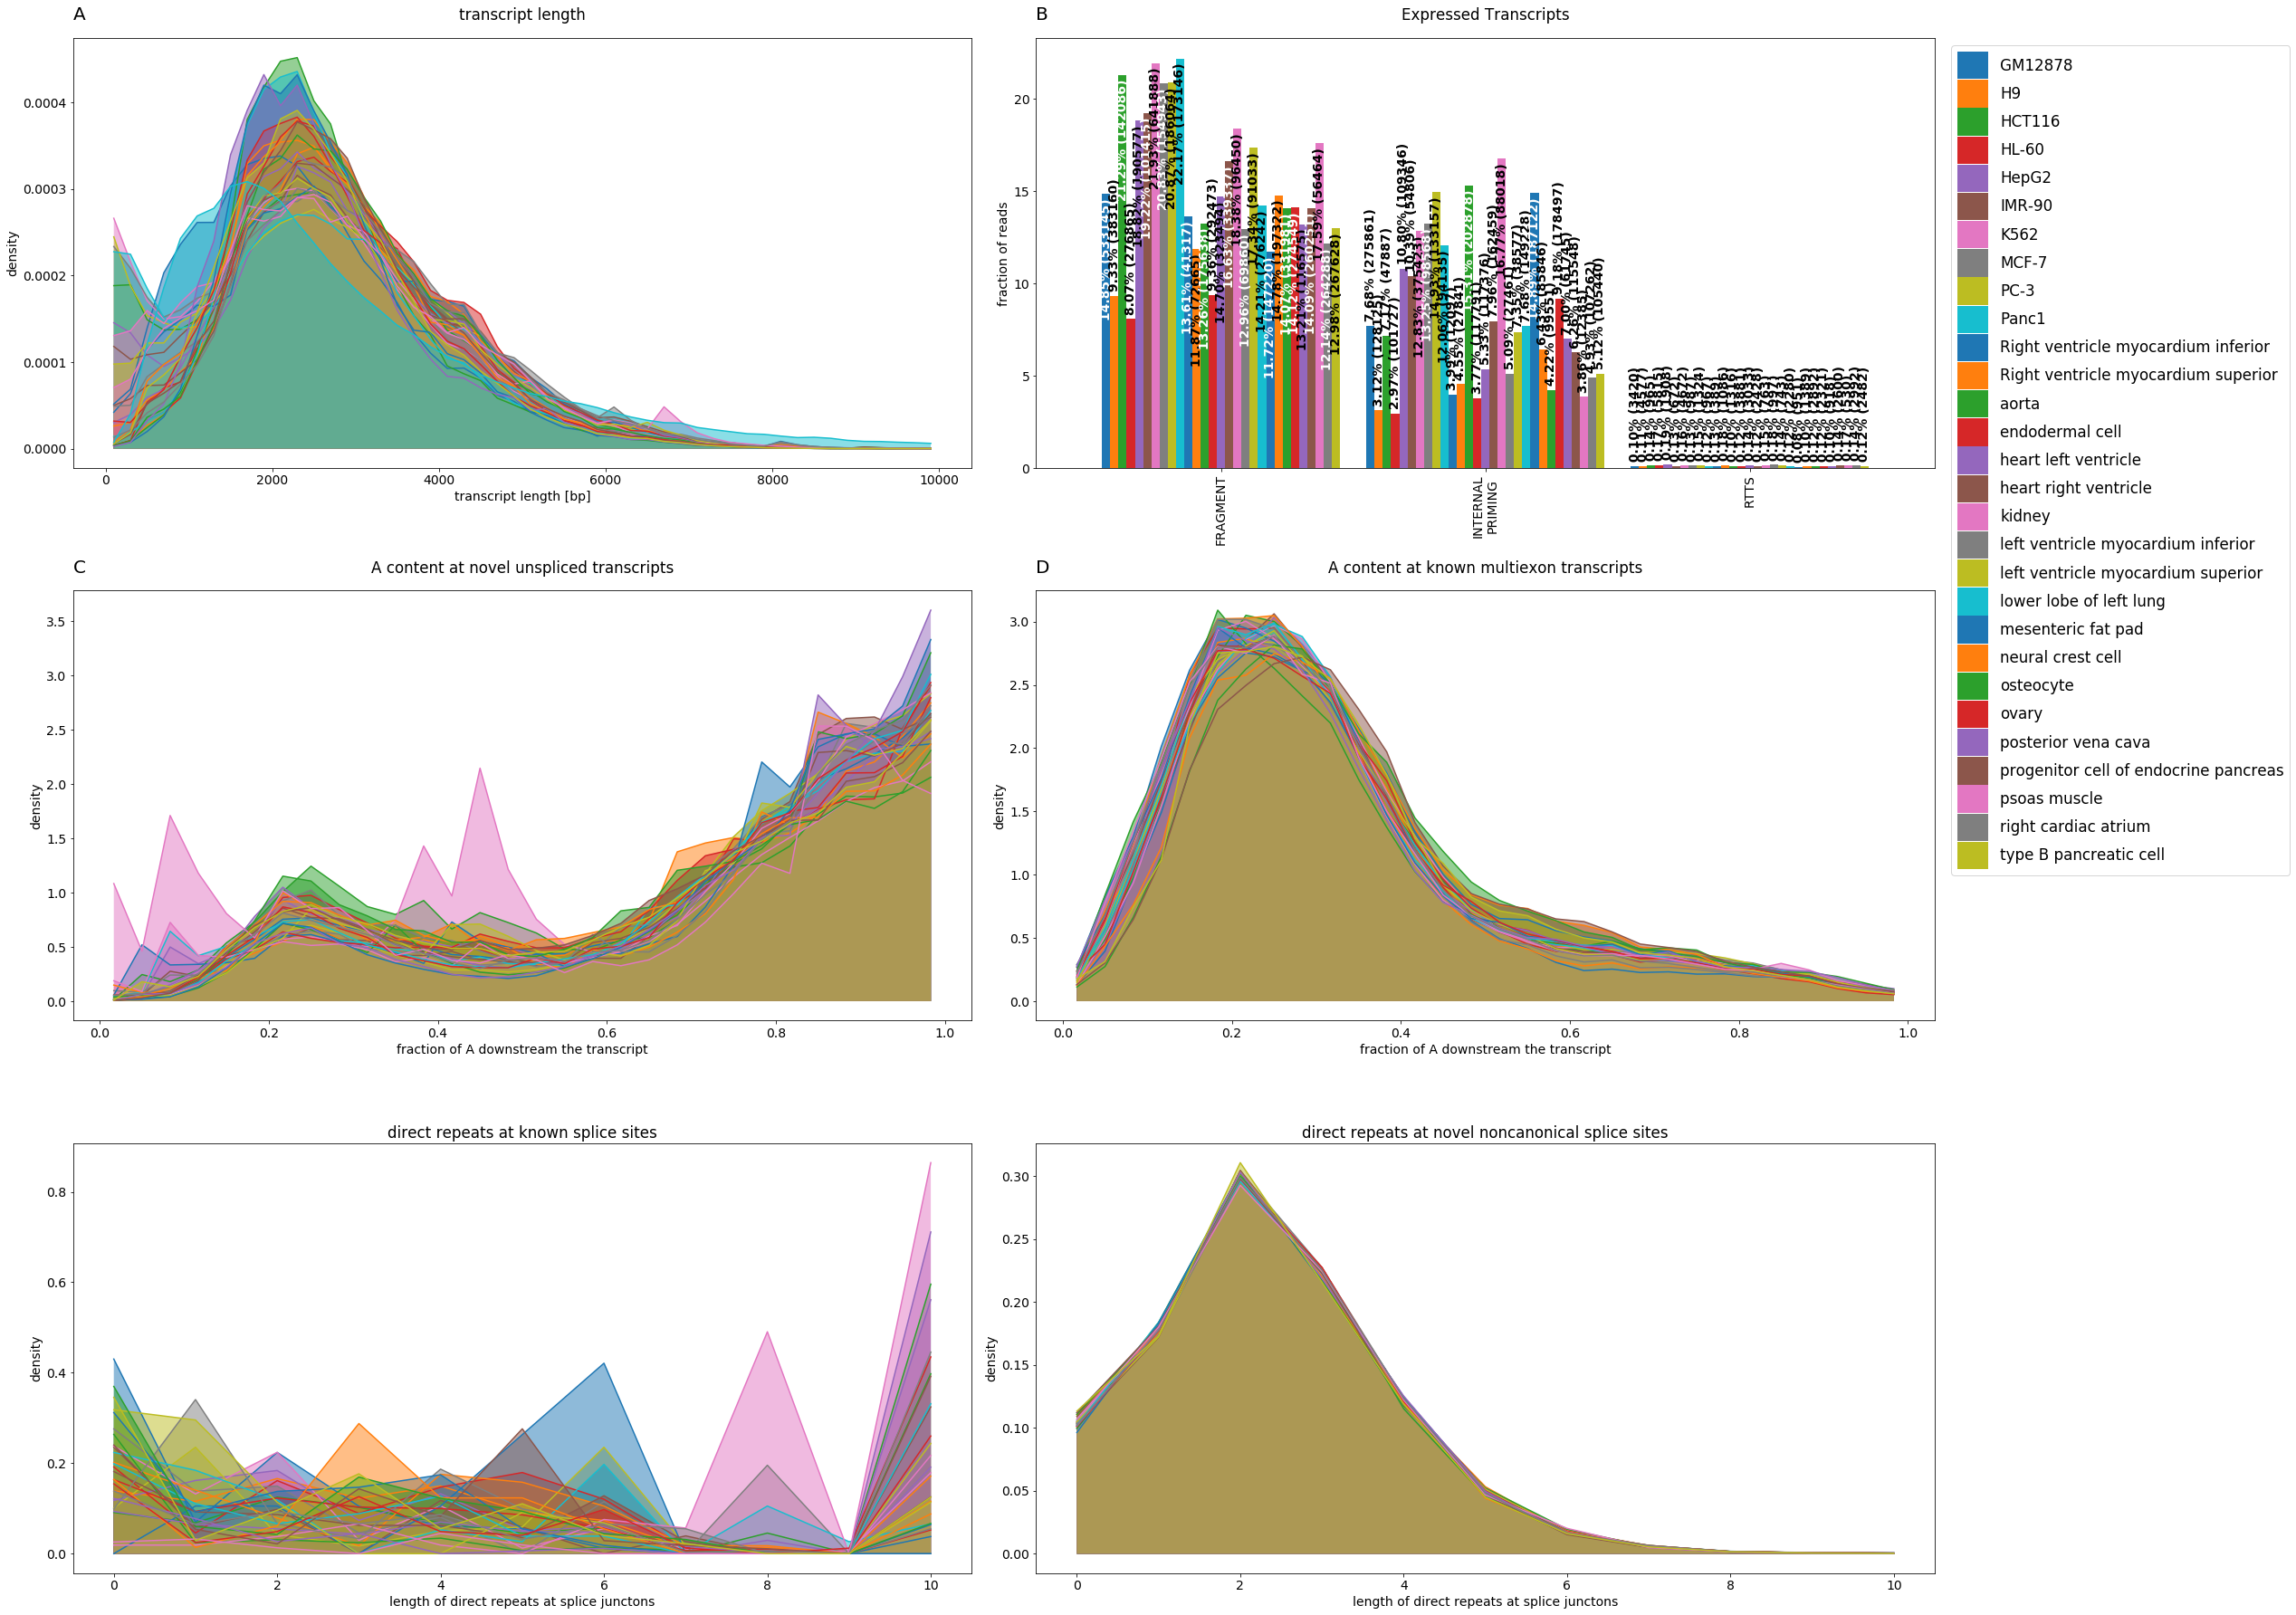

In [6]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],legend=False,**tr_stats[0][1])  
#D) frequency of artifacts
plot_bar(f_stats[0],ax=axs[0,1],drop_categories=['MULTIEXON','NOVEL\nTRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL\nSPLICING' ],bar_width=.9,legend=False,**f_stats[1])  
#B) internal priming
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'novel' in c]],smooth=3,ax=axs[1,0],legend=False,density=True,fill=True, title= 'A content at novel unspliced transcripts', xlabel='fraction of A downstream the transcript')  
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'known' in c]],smooth=3,ax=axs[1,1],legend=False,density=True,fill=True, title= 'A content at known multiexon transcripts', xlabel='fraction of A downstream the transcript')  
#C) RTTS
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'novel' in c]],ax=axs[2,0],legend=False,density=True,title='direct repeats at known splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'known' in c]],ax=axs[2,1],legend=False,density=True,title='direct repeats at novel noncanonical splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)
fig.tight_layout()
axs[0,1].legend(fontsize='large', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.01, 1))


In [7]:
f_stats_sample=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1)


Quality metrics vary substantially between the individual samples. This can be depicted as a bar chart.

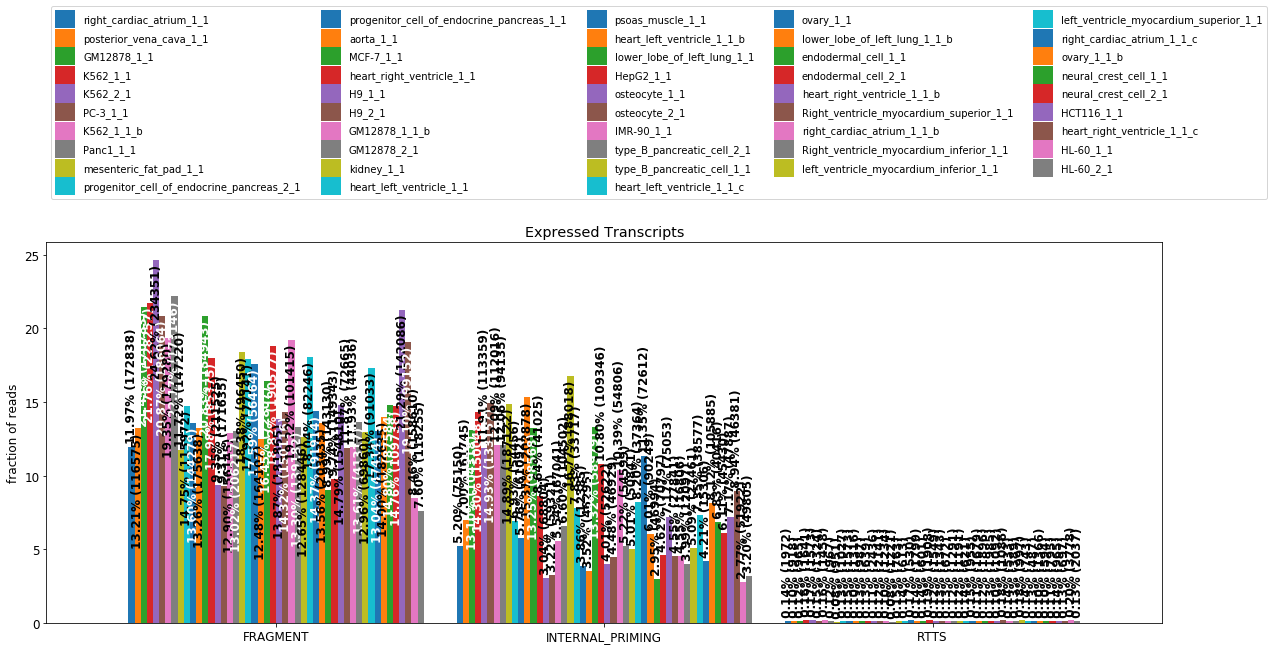

In [41]:
#plot technical artifacts for individual samples
plt.rcParams["figure.figsize"] = (20,7)
plot_bar(f_stats_sample[0],drop_categories=['MULTIEXON','NOVEL_TRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL_SPLICING' ],legend=False,rot=0, bar_width=.9,**f_stats_sample[1])  
plt.legend(fontsize='small', ncol=5,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')

## Data exploration
To explore the relation of the samples with respect to splicing we look at PCA and UMAP embeddings based on alternative splicing events.

In [9]:
#Compute alternative splicing events by finding "bubbles" in the segment graphs
splice_events=isoseq.alternative_splicing_events()

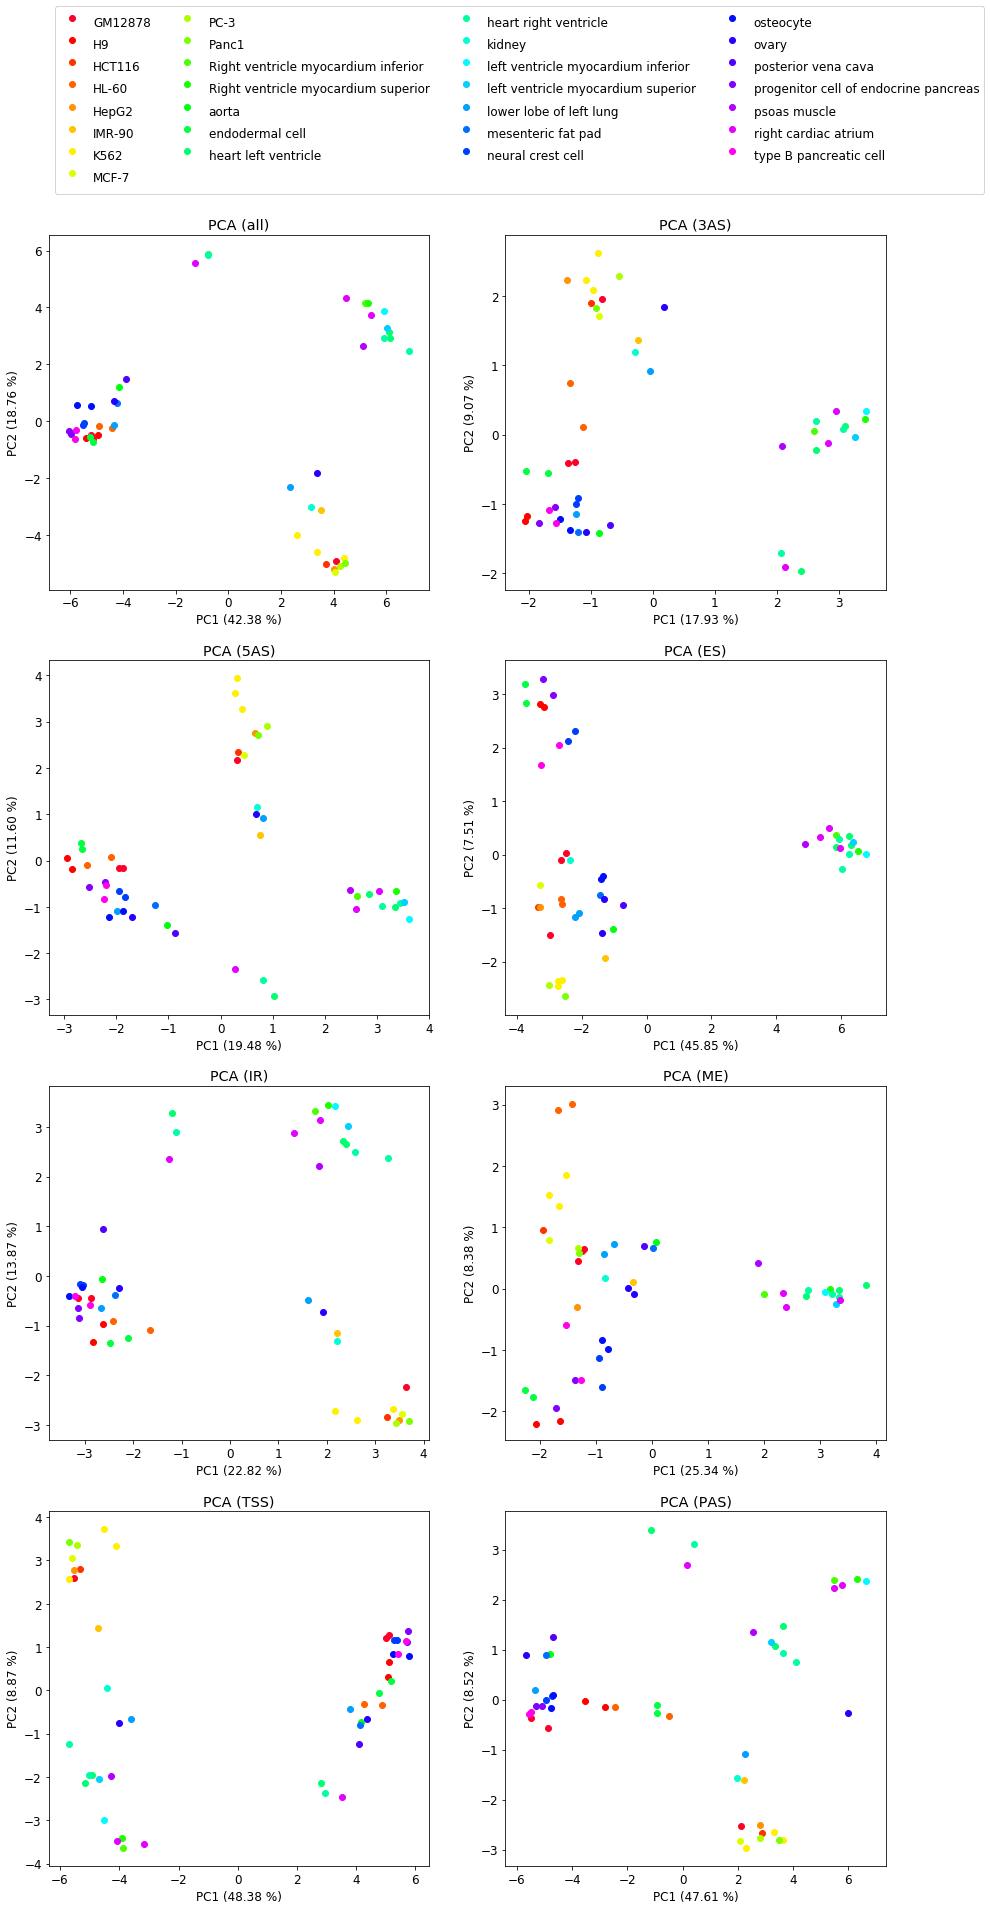

In [42]:
#plot PCA embedding
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (15,30)

pca={}

f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    pca[t]=plot_embedding(splice_events, ax=ax, labels=False, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')
#plt.tight_layout()


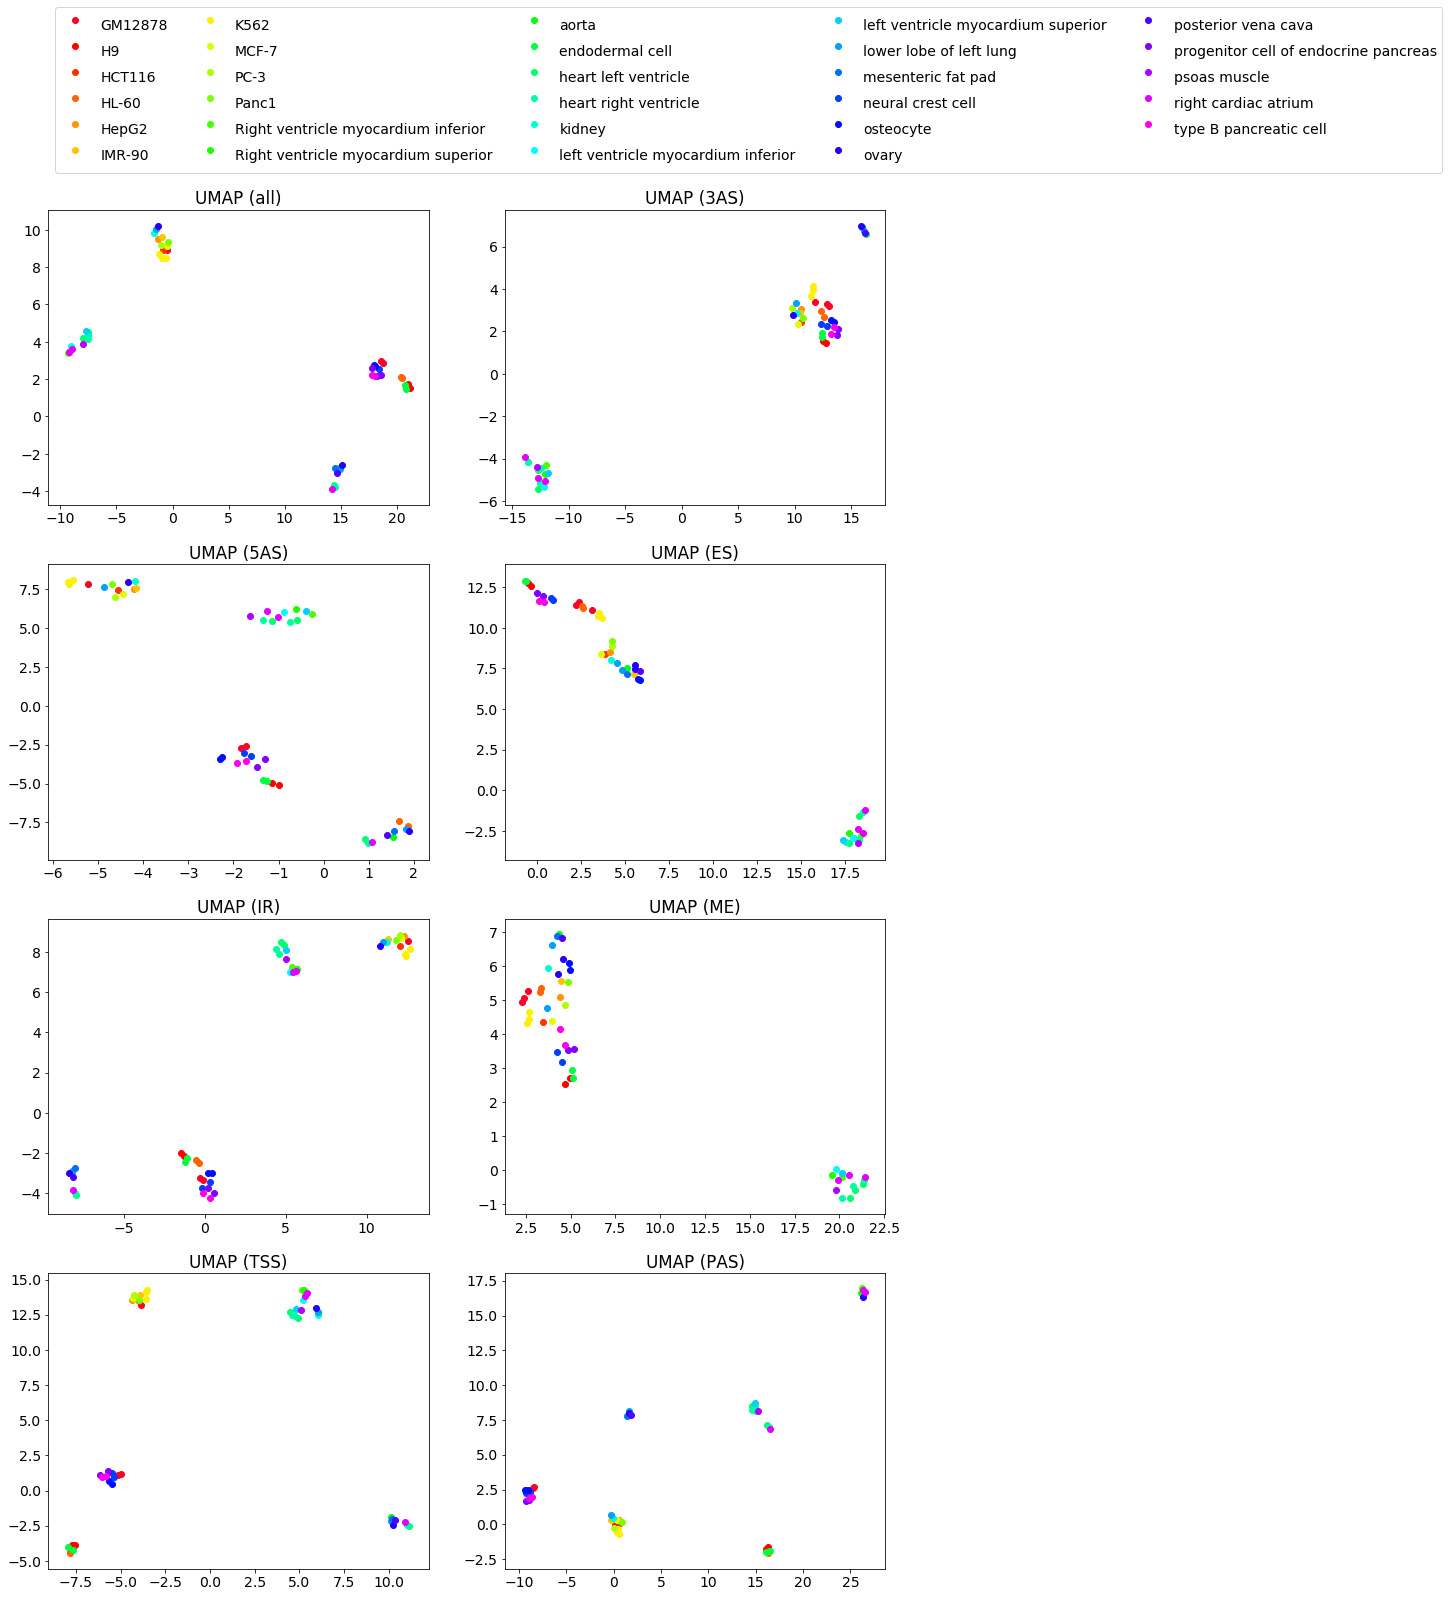

In [11]:
#plot UMAP embedding 
# the clustering of samples very much depends on the n_neighbors parameter
plt.rcParams["figure.figsize"] = (15,25)
umap={}
f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    umap[t]=plot_embedding(splice_events, method='UMAP',n_neighbors=6, ax=ax, labels=False, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')


INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples K562_1_1, K562_2_1, PC-3_1_1, K562_1_1_b, Panc1_1_1, MCF-7_1_1, HepG2_1_1, HCT116_1_1,

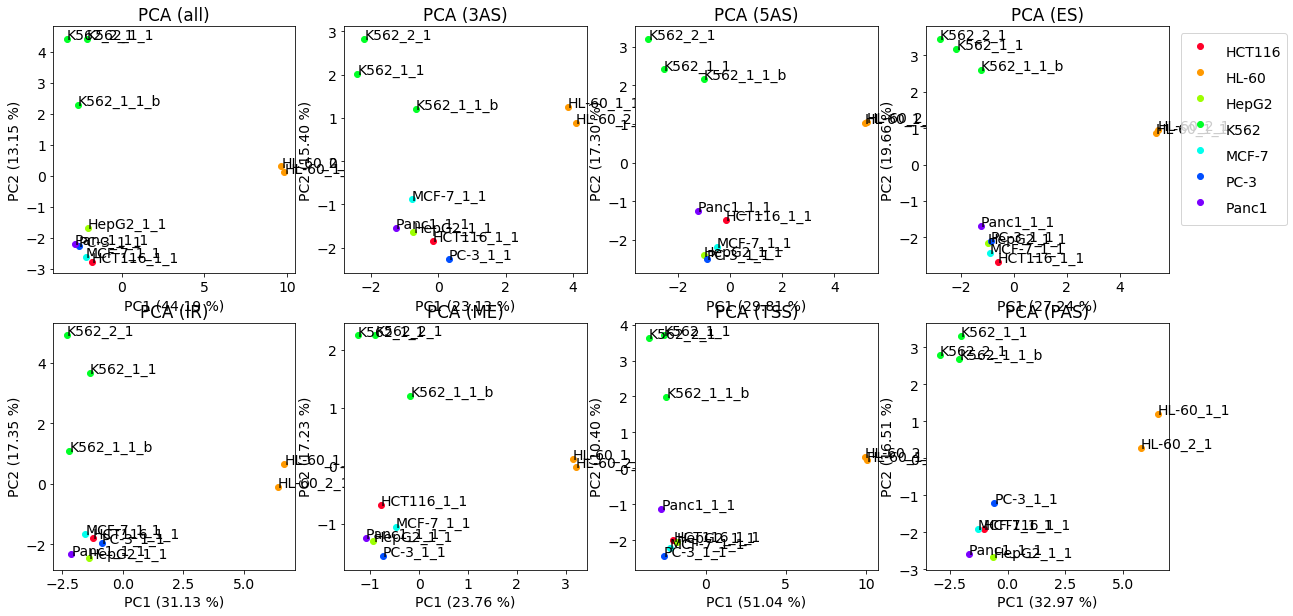

In [12]:
#plot PCA embedding of cancer cell lines only
#This seperates leukemia cell lines from carcinoma cell lines
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in karyotype['cancer']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=True, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

INFO:restricting embedding on samples right_cardiac_atrium_1_1, heart_right_ventricle_1_1, heart_left_ventricle_1_1, heart_left_ventricle_1_1_b, heart_left_ventricle_1_1_c, heart_right_ventricle_1_1_b, Right_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_b, Right_ventricle_myocardium_inferior_1_1, left_ventricle_myocardium_inferior_1_1, left_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_c, heart_right_ventricle_1_1_c
INFO:restricting embedding on samples right_cardiac_atrium_1_1, heart_right_ventricle_1_1, heart_left_ventricle_1_1, heart_left_ventricle_1_1_b, heart_left_ventricle_1_1_c, heart_right_ventricle_1_1_b, Right_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_b, Right_ventricle_myocardium_inferior_1_1, left_ventricle_myocardium_inferior_1_1, left_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_c, heart_right_ventricle_1_1_c
INFO:restricting embedding on samples right_cardiac_atrium_1_1, heart_right_ventricle_1_1, heart_left_ve

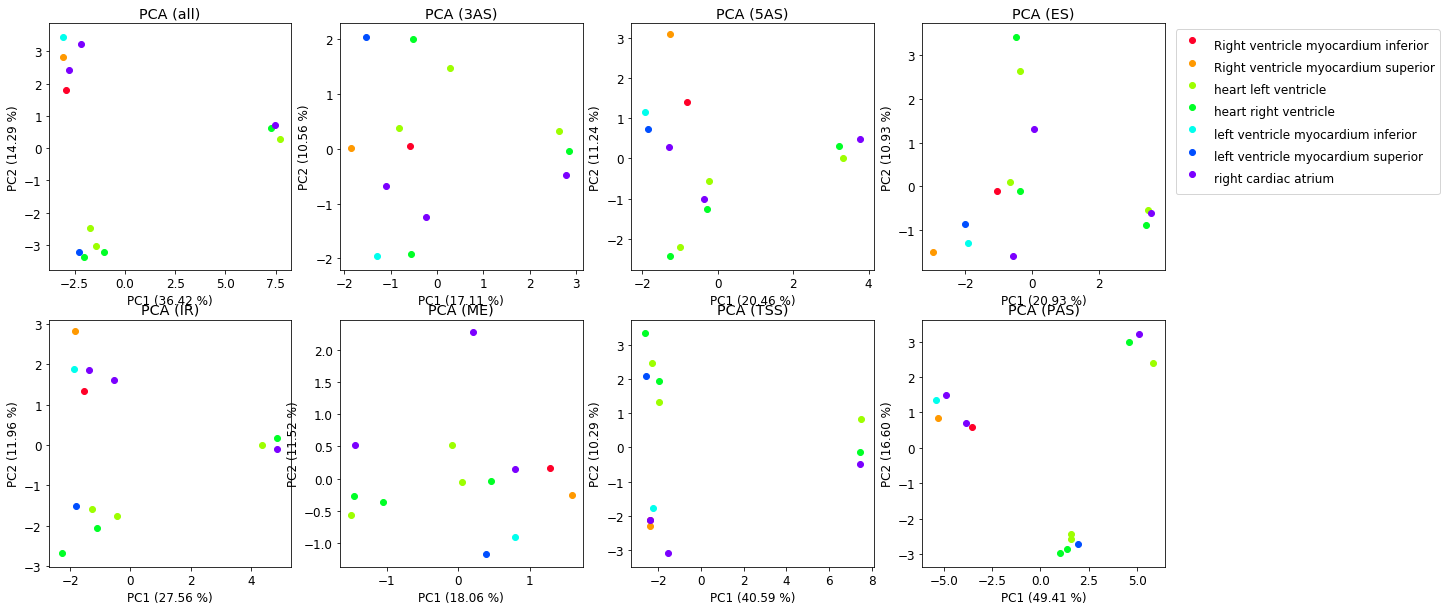

In [44]:
#plot PCA embedding of heart samples only
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in organ['heart']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=False, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

## Novel alternative splicing classification

In [13]:

cname=['FSM','ISM','NIC','NNC','novel gene']
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

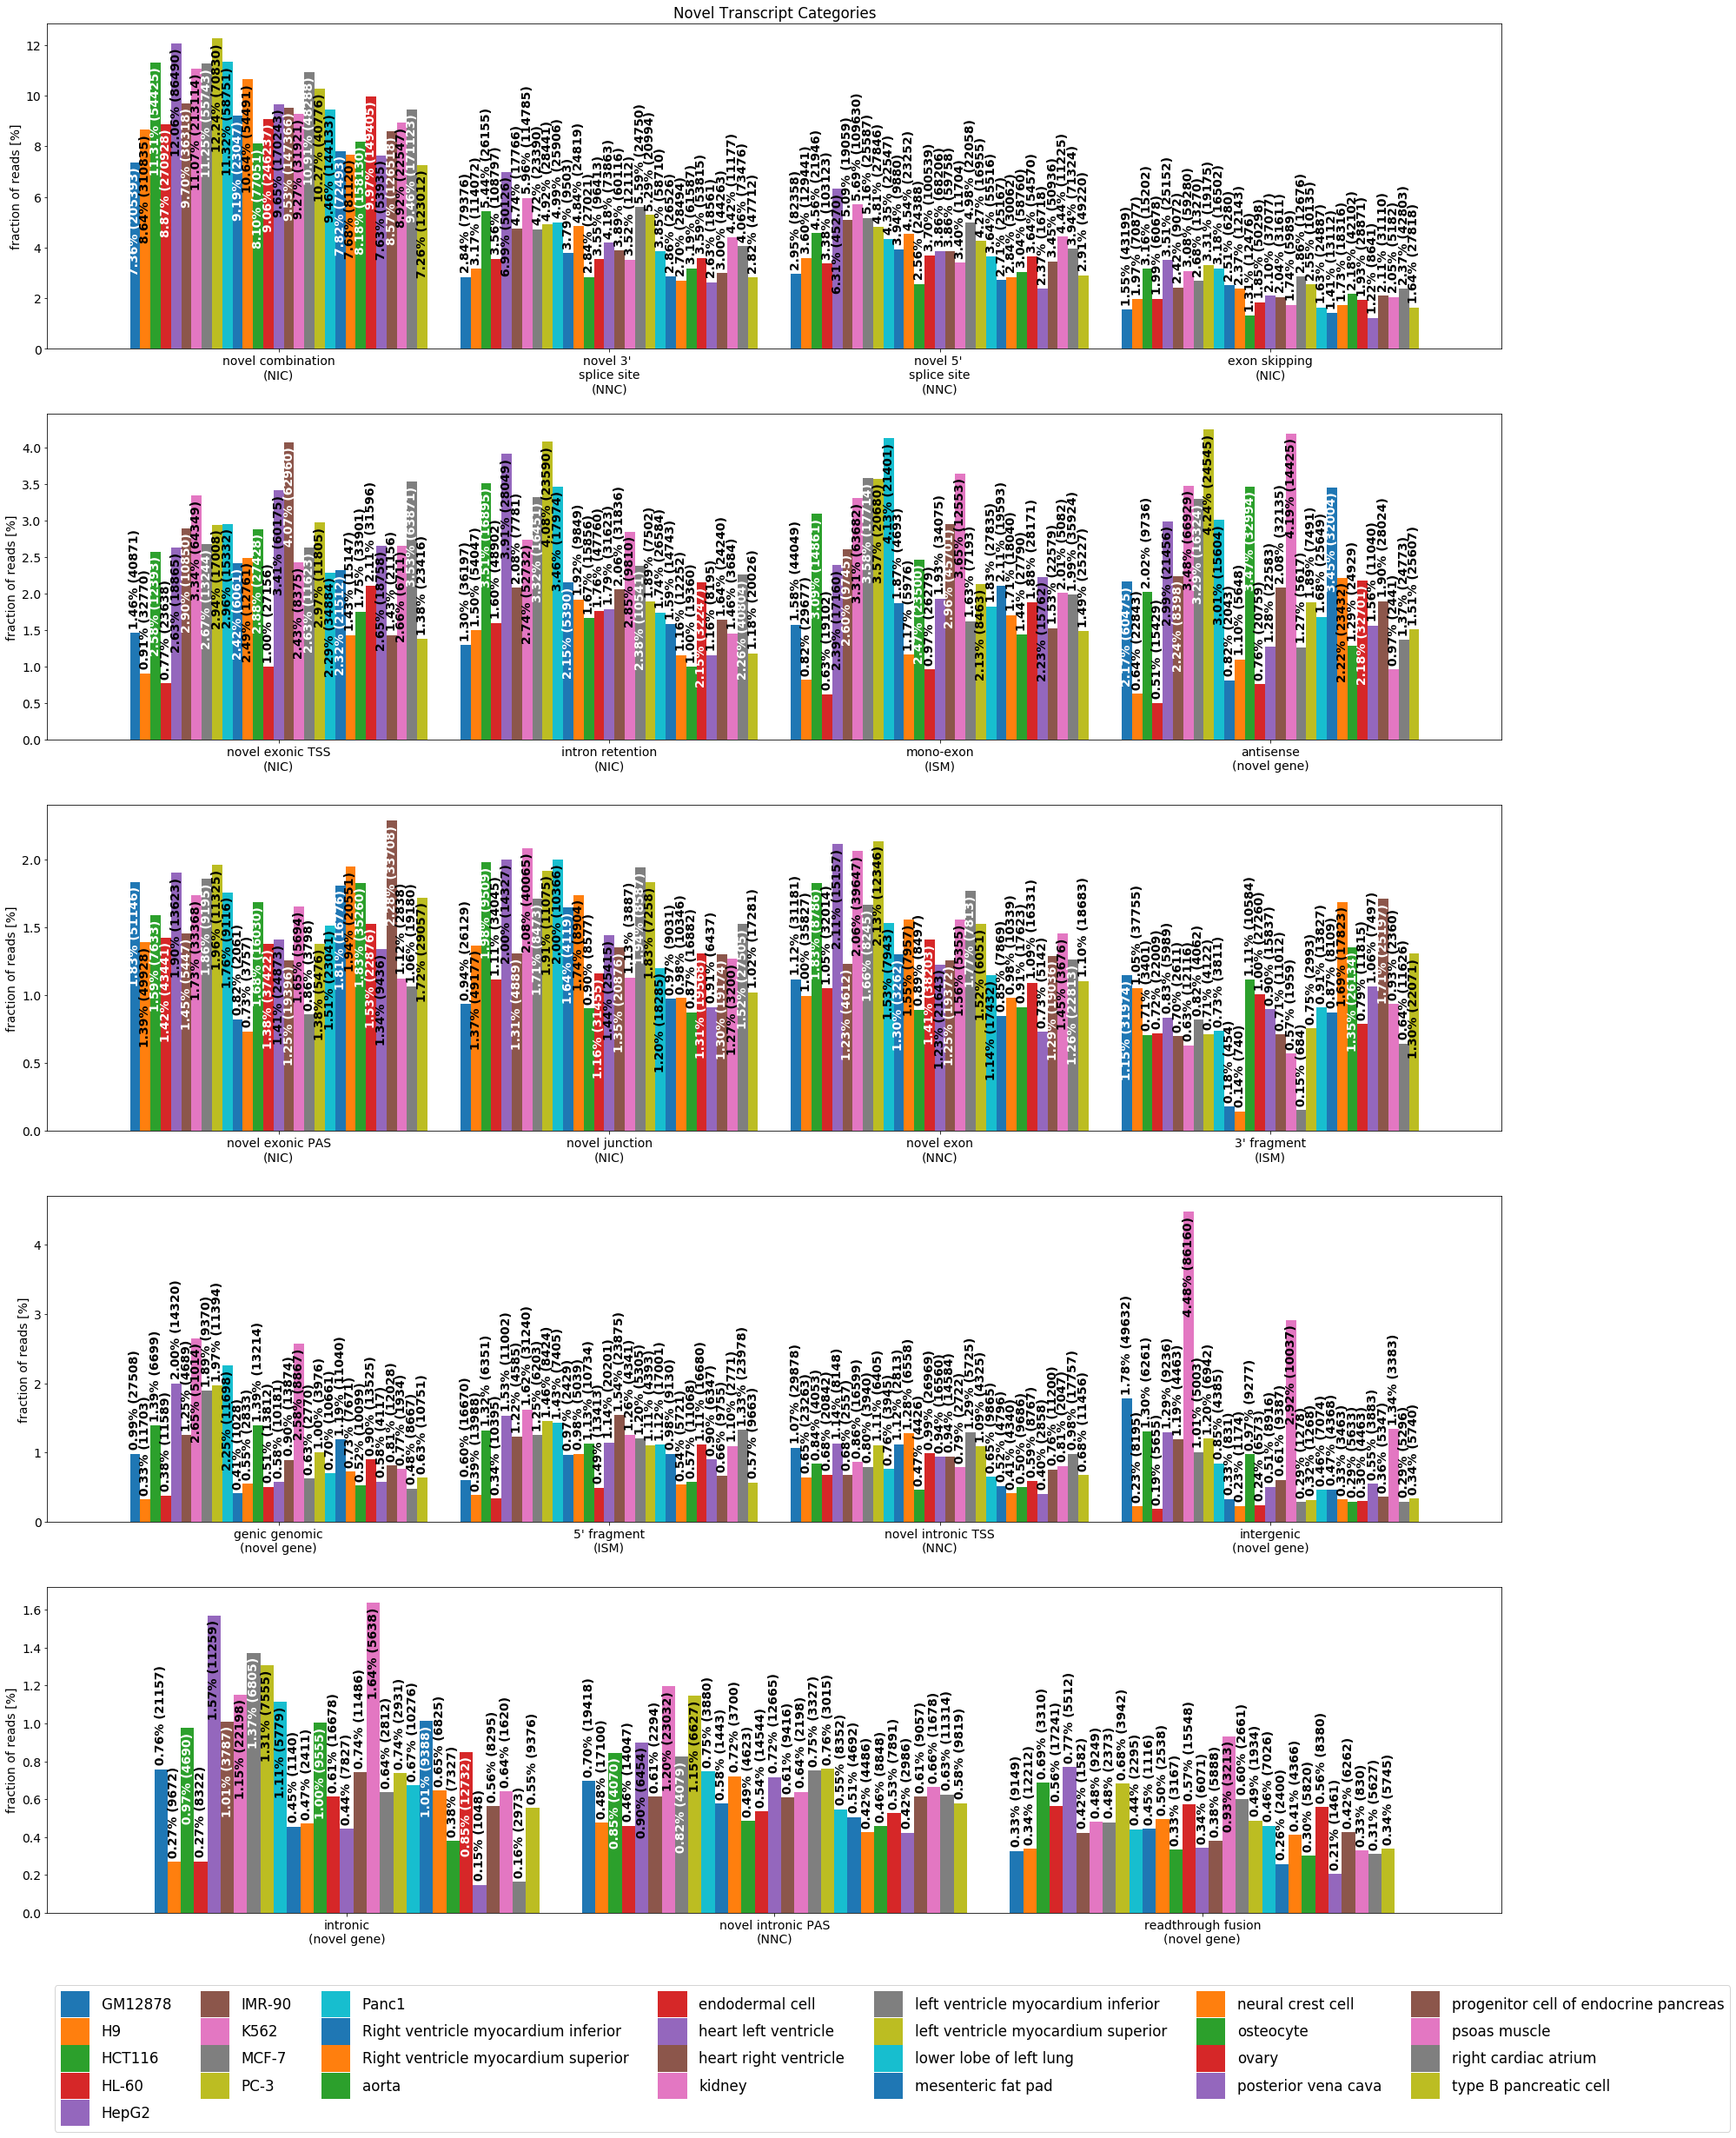

In [14]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,40)
fig, axs = plt.subplots( 5)
for i,ax in enumerate(axs):
    cat=altsplice[0][0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice[0][0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice[0][0].index if c not in cat])  
axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

In [15]:
#The same for individual samples
altsplice_sample= isoseq.altsplice_stats( weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))
altsplice_sample[0].index=altsplice_sample[0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice_sample[0].index]


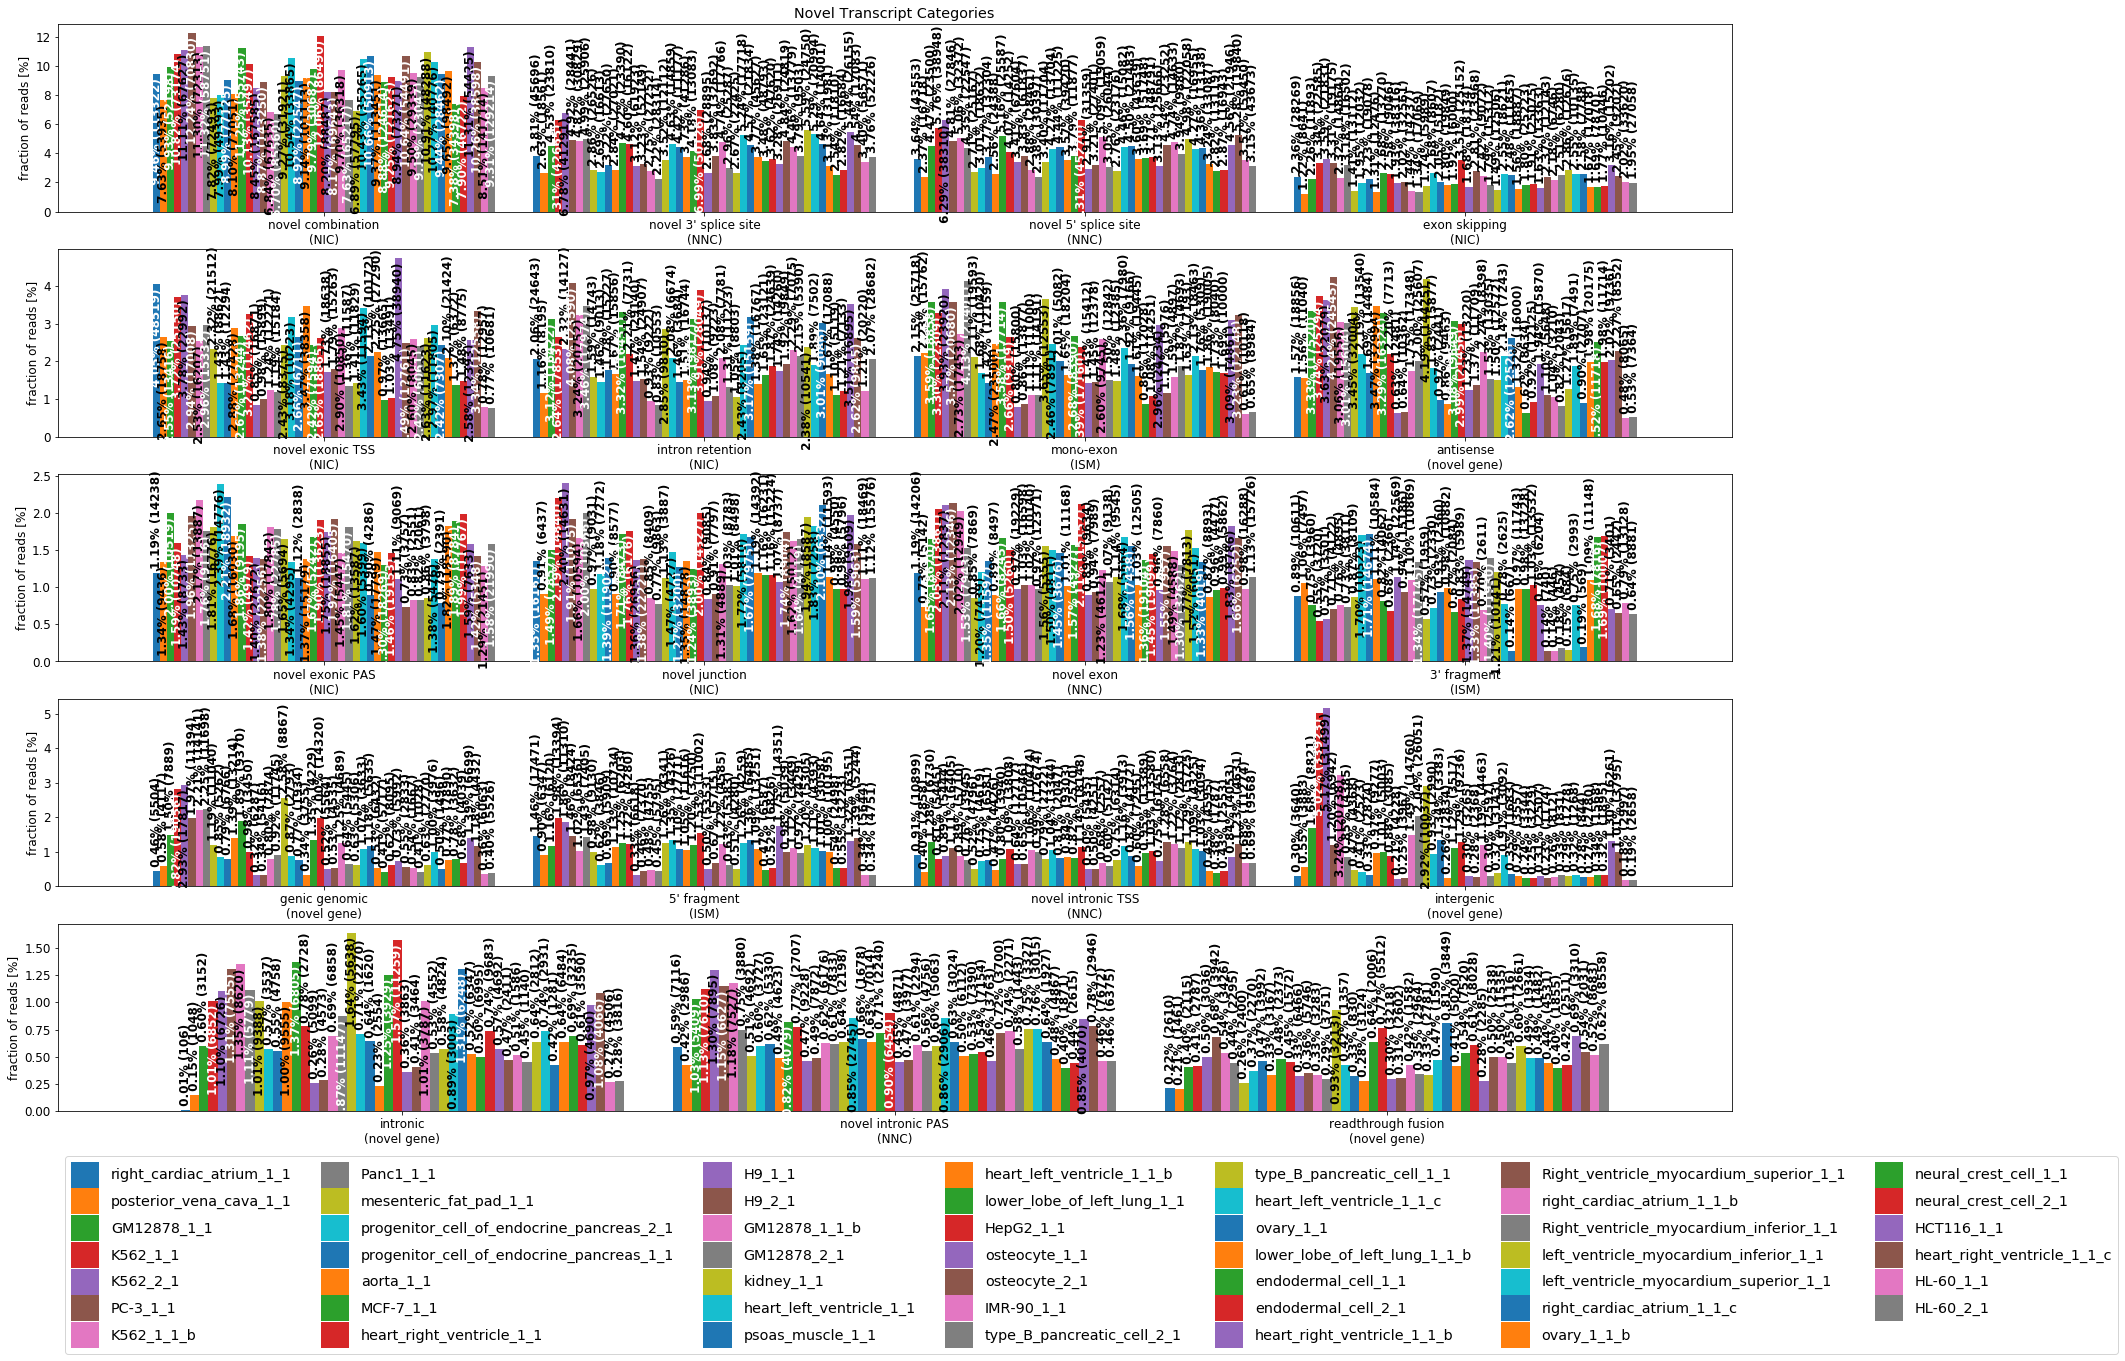

In [16]:
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots( 5)


for i,ax in enumerate(axs.flatten()):
    cat=altsplice_sample[0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice_sample[0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice_sample[0].index if c not in cat])  
handles, labels = axs[0].get_legend_handles_labels()

axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

## Differential splicing

To test for differential splicing events between groups of samples, IsoTools implements a likelihood ratio test based on beta binomial distribution. 
For each alternative event, the number of reads supporting the alternative is modeled with a binomial distribution, where the probability parmeter is beta distributed. For the null model, we fit one set of maximum likelihood parameters of the beta distribution for all samples, whereas for the alternative model, a set of parameters if fitted for each group. Under the null hypothesis, the model deviance is assumed to follow a chi2 distribution with two degrees of freedom.

Each comparision results in table of alternative splicing events, sorted by significance. 
To explore the results, we can plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
We can also look at individual examples and depict the event as a sashimi plot. 
To this end, we define a helper function, to automatically identify the relevant region and the involved junctions and make the sashimi plot:


In [17]:
#first we define a function, to depcit the results
def plot_diff_example(row, isoseq, groups):
    #sashimi plot for differential spliced genes
    plt.rcParams["figure.figsize"] = (15,10)
    #select gene object
    g=isoseq[row.gene_id]
    #make the title
    gn=list(groups)
    novel='novel' if row.novel else 'known'
    title=f'{g.name} {row.splice_type} ({novel}) FDR={row.padj:.2e}: {gn[0]}={row[gn[0]+"_PSI"]*100:.1f} vs {gn[1]}={row[gn[1]+"_PSI"]*100:.1f} PSI'
    print(title)
    start=row.start
    end=row.end
    #select the junctions of interest (which will be marked purple in the plot)
    joi=[(start,end)]
    if row.splice_type=='ME' and g.is_annotated:
        try:
            sg=g.ref_segment_graph
            n1=next(n for n in sg if n[1]==start)
            n2=next(n for n in sg if n[0]==end)
            joi={(start,sg[suc].start) for suc in n1.suc.values() if sg[suc].start<end }
            joi.update({(sg[pre].end,end) for pre in n2.pre.values() if sg[pre].end>start })
        except:
            pass
    #draw the plot for the two sample groups from the comparison
    f,axs=g.sashimi_figure(samples=groups , x_range=(start-500, end+500),junctions_of_interest=joi    )
    axs[0].set_title(title)
    fig.tight_layout()

In [18]:
from isotools.plots import plot_diff_results
#We are mostly interested in differential splicing. Alternative TSS and PAS are ignored for now. 
types_of_interest=['ES','ME','5AS','3AS']
#dict to store the results in
res={}

### Normal endodermal development
As a first example, we compare the embryonic stem cell line H9 vs in vitro derived endodermal cells.

In [19]:
diff_cmp='H9/endodermal cell'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 20 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for H9 (2) vs endodermal cell (2) using betabinom_lr test
100%|██████████| 589580/589580 [17:54<00:00, 548.76it/s]  


482 differential splice sites in 338 genes for H9 vs endodermal cell


index    gene             gene_id  chrom strand      start        end  \
0   17030   VDAC1  ENSG00000213585.11   chr5      -  133993015  134004646   
3   10094   CNDP2  ENSG00000133313.15  chr18      +   74496431   74499936   
4   19781   SARAF  ENSG00000133872.14   chr8      -   30070059   30082846   
7    5071   RPLP0  ENSG00000089157.16  chr12      -  120200831  120201082   
8   13858   CXADR  ENSG00000154639.19  chr21      +   17559131   17565427   
9    7159  ZFAND6  ENSG00000086666.19  chr15      +   80059809   80120327   
14   9798    DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
32   9797    DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
34   8506    IST1  ENSG00000182149.21  chr16      +   71922680   71924768   
38   2598   NODAL  ENSG00000156574.10  chr10      -   70433088   70435285   

   splice_type  novel      padj  ...  total_PSI  total_disp  H9_1_1_H9_in_cov  \
0          3AS  False  0.019676  ...   0.397676    0.097684              2114   
3          3AS  False  0.019676  ...   0.438431    0.045426              1181   
4           ES  False  0.019676  ...   0.525469    0.069543              1074   
7          3AS  False  0.022672  ...   0.406459    0.080456               339   
8           ES  False  0.022672  ...   0.602567    0.085512                84   
9           ES  False  0.022672  ...   0.504624    0.076068               191   
14         5AS   True  0.026060  ...   0.592848    0.095463                57   
32          ES   True  0.042996  ...   0.749084    0.033310               225   
34          ES  False  0.045729  ...   0.573786    0.034286               925   
38          ES   True  0.047064  ...   0.336482    0.066385                73   

    H9_1_1_H9_total_cov  H9_2_1_H9_in_cov  H9_2_1_H9_total_cov  \
0                  2705              1818                 2307   
3                  1777              1002                 1471   
4                  1302               924                 1118   
7                   437               169                  238   
8                   378                90                  322   
9                   235               174                  208   
14                  248                46                  235   
32                  416               253                  442   
34                 1188               789                 1037   
38                 1308                80                 1099   

    endodermal_cell_1_1_endodermal cell_in_cov  \
0                                           26   
3                                          169   
4                                           63   
7                                          161   
8                                          680   
9                                           83   
14                                         216   
32                                         189   
34                                          51   
38                                          93   

    endodermal_cell_1_1_endodermal cell_total_cov  \
0                                             393   
3                                             831   
4                                             264   
7                                            1746   
8                                             734   
9                                             466   
14                                            229   
32                                            202   
34                                            147   
38                                            137   

    endodermal_cell_2_1_endodermal cell_in_cov  \
0                                           14   
3                                          161   
4                                           64   
7                                           77   
8                                          690   
9                                           90   
14                                         191   
32

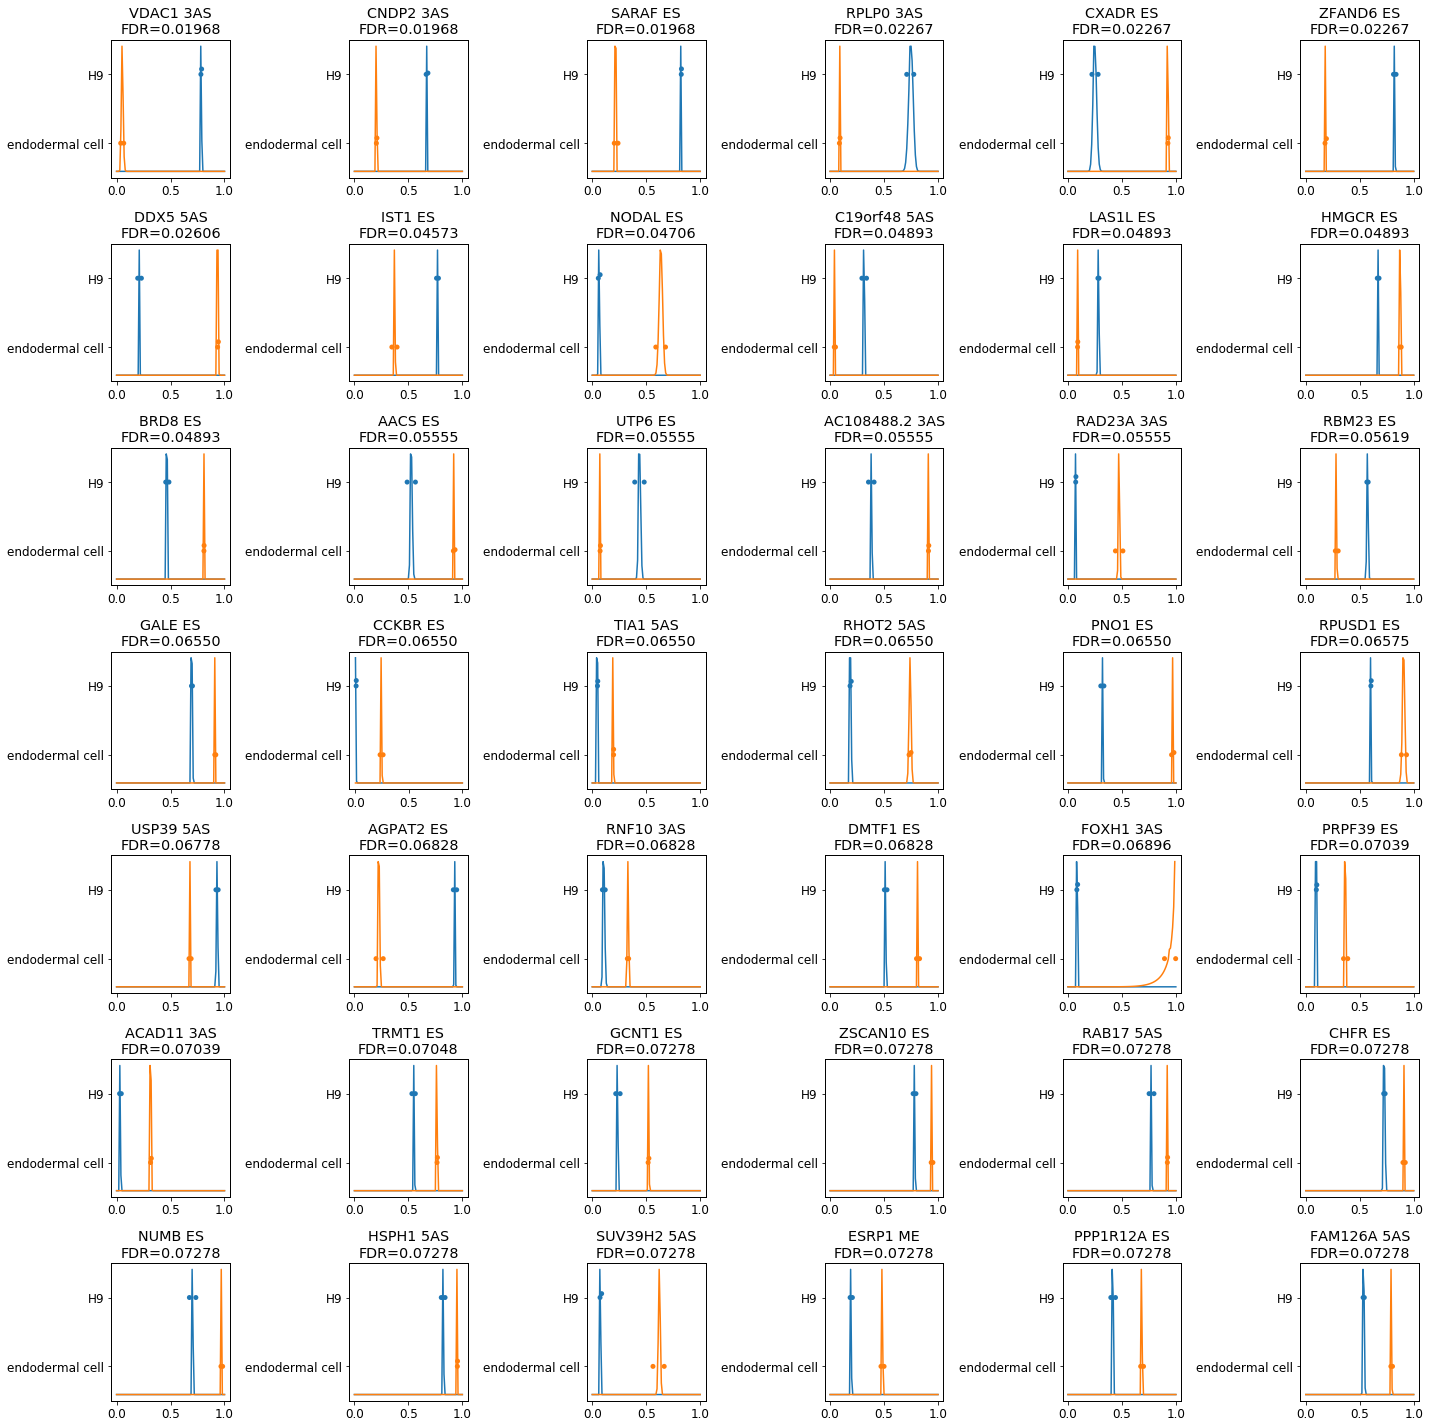

In [20]:
#plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

CXADR ES (known) FDR=2.27e-02: H9=24.9 vs endodermal cell=92.8 PSI


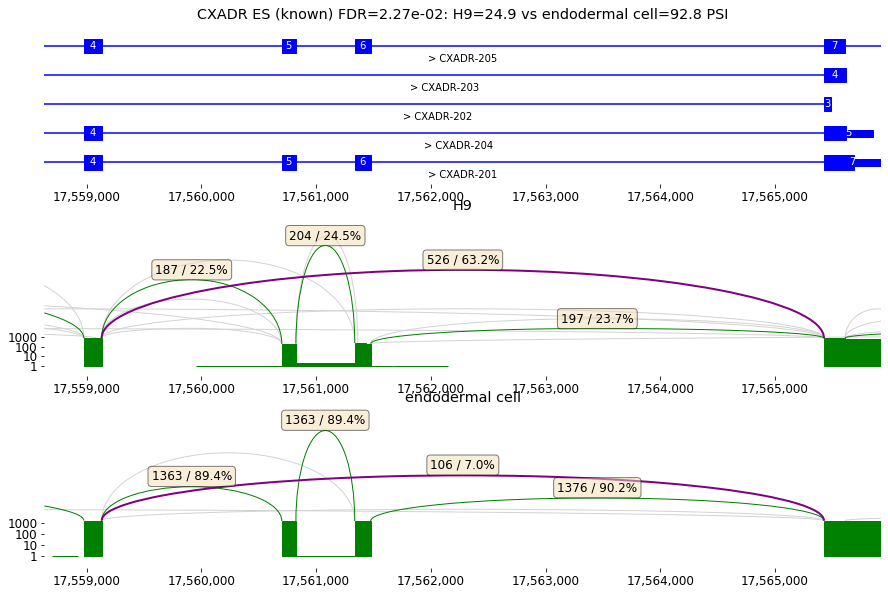

In [21]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[8]
plot_diff_example(row, isoseq, groups)

### Leukemia cell lines
Both leukemia cell lines HL-60 and K562 (should) have mutations in the splicing machinery, e.g. in the SRSF2 gene, which should lead to abberant splicing. We compare them to the B-cell derived cell line GM12878.

See Urbanski et al: Alternative-splicing defects in cancer: splicing regulators and their downstream targets, guiding the way to novel cancer therapeutics
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002934/


In [22]:
diff_cmp='GM12878/HL-60'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#
#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs HL-60 (2) using betabinom_lr test
100%|██████████| 589580/589580 [16:17<00:00, 603.14it/s] 


5388 differential splice sites in 3137 genes for GM12878 vs HL-60


index     gene             gene_id  chrom strand      start        end  \
2   14914  HNRNPDL  ENSG00000152795.17   chr4      -   82424883   82426036   
8    1220   LGALS8  ENSG00000116977.19   chr1      +  236542787  236543559   
9   12535   NELFCD  ENSG00000101158.15  chr20      +   58993675   58994109   
15   5962   HNRNPC  ENSG00000092199.18  chr14      -   21230366   21230996   
16  15523   FIP1L1  ENSG00000145216.16   chr4      +   53399839   53425871   
21   3660  DCUN1D5  ENSG00000137692.12  chr11      -  103066567  103083255   
22  14333  LRRFIP2  ENSG00000093167.18   chr3      -   37083806   37094791   
23   2879  XPNPEP1  ENSG00000108039.18  chr10      -  109907815  109923401   
28  18733    PUF60  ENSG00000179950.14   chr8      -  143818534  143821596   
30   7599    LUC7L  ENSG00000007392.17  chr16      -     208188     220648   

   splice_type  novel      padj  ...  GM12878_1_1_GM12878_in_cov  \
2           ES  False  0.015755  ...                          12   
8           ES  False  0.015755  ...                          13   
9          5AS  False  0.015755  ...                         136   
15         5AS  False  0.015755  ...                         168   
16          ES  False  0.015755  ...                          97   
21          ES  False  0.015755  ...                          86   
22          ES  False  0.015755  ...                          29   
23          ES  False  0.015755  ...                          56   
28          ES  False  0.015755  ...                         252   
30          ES  False  0.015755  ...                           2   

    GM12878_1_1_GM12878_total_cov  GM12878_1_1_b_GM12878_in_cov  \
2                             211                            24   
8                              17                            82   
9                             163                           357   
15                            791                           325   
16                            147                           175   
21                             86                           222   
22                             76                            40   
23                             58                           182   
28                            413                           330   
30                             49                             3   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
2                               898                          37   
8                               111                         107   
9                               398                         361   
15                             1783                         387   
16                              274                         159   
21                              223                         289   
22                              123                          25   
23                              190                         197   
28                              630                          95   
30                               74                           5   

    GM12878_2_1_GM12878_total_cov  HL-60_1_1_HL-60_in_cov  \
2                            1496                   321.0   
8                             150                    14.0   
9                             409                    18.0   
15                           2090                    90.0   
16                            243                   190.0   
21                            292                   117.0   
22                             81                   102.0   
23                            204                   141.0   
28                            154                   170.0   
30                             95                    65.0   

    HL-60_1_1_HL-60_total_cov  HL-60_2_1_HL-60_in_cov  \
2                       486.0                   173.0   
8                       154.0                     9.0   
9                       161.0                    22.0   
15                  

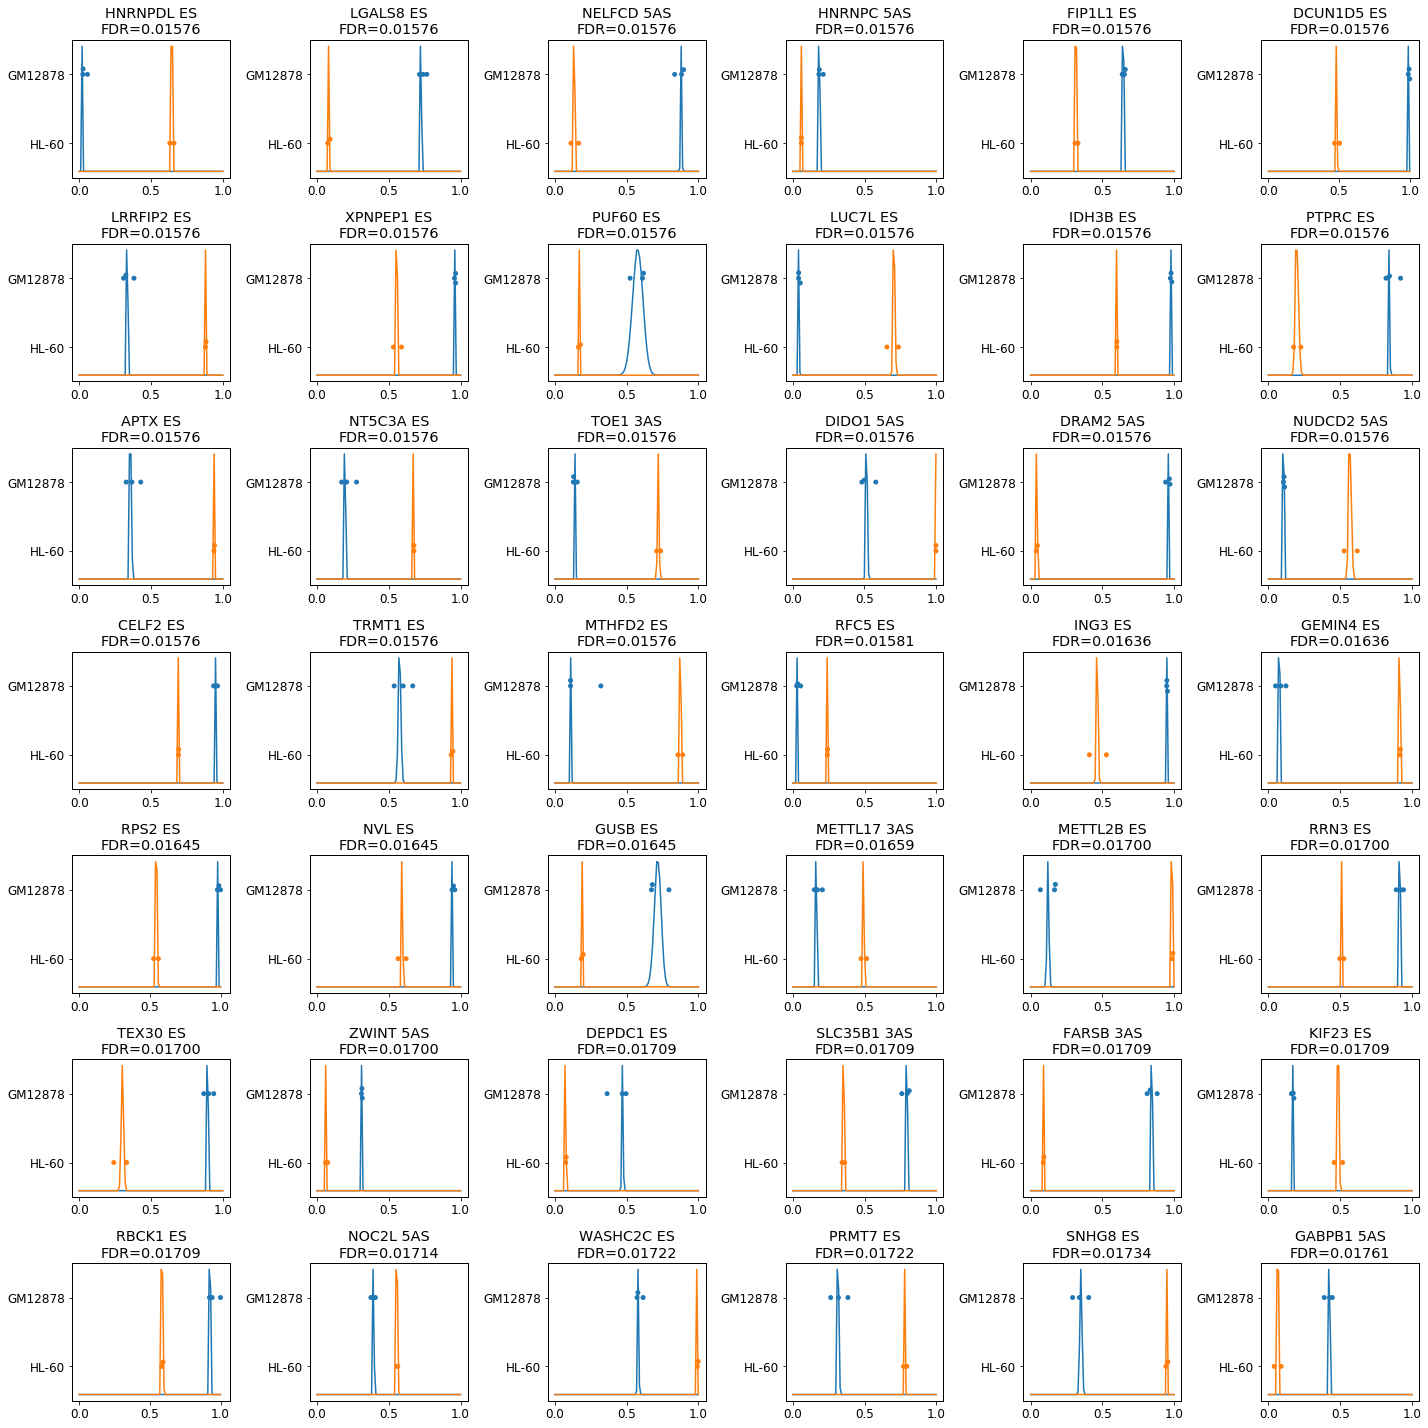

In [23]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

HNRNPDL ES (known) FDR=1.58e-02: GM12878=2.8 vs HL-60=65.0 PSI


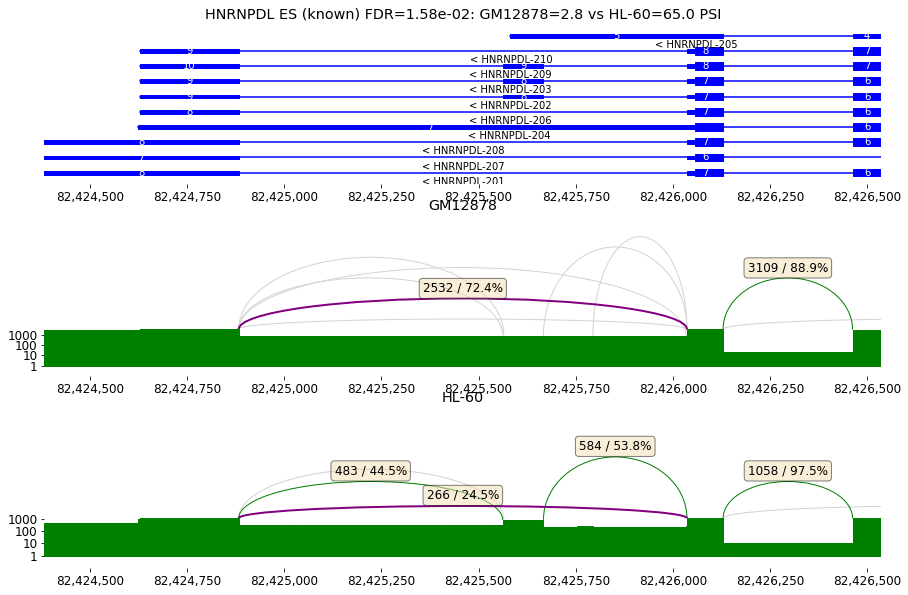

In [49]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,20)
#1) select gene of interest: 2nd row, exon skipping of HNRNPDL
row=res[diff_cmp].iloc[2]
plot_diff_example(row, isoseq, groups)

In [25]:
diff_cmp='GM12878/K562'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs K562 (3) using betabinom_lr test
100%|██████████| 589580/589580 [19:20<00:00, 508.24it/s]  


3927 differential splice sites in 2559 genes for GM12878 vs K562


index      gene             gene_id  chrom strand      start        end  \
0    4572      CD59  ENSG00000085063.17  chr11      -   33722463   33736381   
1    1288     CKS1B  ENSG00000173207.13   chr1      +  154974804  154977986   
8    4068    MRPL21  ENSG00000197345.13  chr11      -   68898012   68900547   
10   5909  RAD51AP1  ENSG00000111247.15  chr12      +    4553147    4558856   
11  14318    POLR2D  ENSG00000144231.11   chr2      -  127850685  127858027   
14  22569     TNPO3  ENSG00000064419.13   chr7      -  129018157  129054650   
16  20089    NUDCD2  ENSG00000170584.11   chr5      -  163457610  163459861   
21  23065    INSIG1  ENSG00000186480.13   chr7      +  155297959  155298258   
32  21633      MPC1  ENSG00000060762.19   chr6      -  166366891  166382805   
39  16272   CSNK2A1  ENSG00000101266.19  chr20      -     508660     543671   

   splice_type  novel      padj  ...  GM12878_1_1_b_GM12878_in_cov  \
0           ES  False  0.009407  ...                           100   
1          5AS  False  0.011474  ...                            13   
8          5AS  False  0.011474  ...                             7   
10          ES  False  0.011474  ...                            43   
11          ES   True  0.011474  ...                           201   
14          ES  False  0.011474  ...                            47   
16         5AS   True  0.011474  ...                            17   
21         5AS  False  0.011474  ...                             5   
32         3AS   True  0.013184  ...                            98   
39          ES  False  0.013184  ...                            67   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
0                               529                         121   
1                               297                          24   
8                               156                          19   
10                               48                          45   
11                              233                         288   
14                              374                          34   
16                              151                          24   
21                               69                           1   
32                              102                         166   
39                              281                          72   

    GM12878_2_1_GM12878_total_cov  K562_1_1_K562_in_cov  \
0                             727                    55   
1                             451                    20   
8                             270                    33   
10                             49                     5   
11                            329                    11   
14                            294                    41   
16                            229                    40   
21                             42                    56   
32                            173                     2   
39                            373                    21   

    K562_1_1_K562_total_cov  K562_2_1_K562_in_cov  K562_2_1_K562_total_cov  \
0                        57                    47                       49   
1                        26                    16                       20   
8                        50                    29                       44   
10                       34                     7                       39   
11                       93                     9                       79   
14                       79                    37                       77   
16                       44                    10                       11   
21                      111                    39                       82   
32                       12                     2                       13   
39                       28                    23                       32   

    K562_1_1_b_K562_in_cov  K562_1_1_b_K562_total_cov  
0                       27                         29  
1   

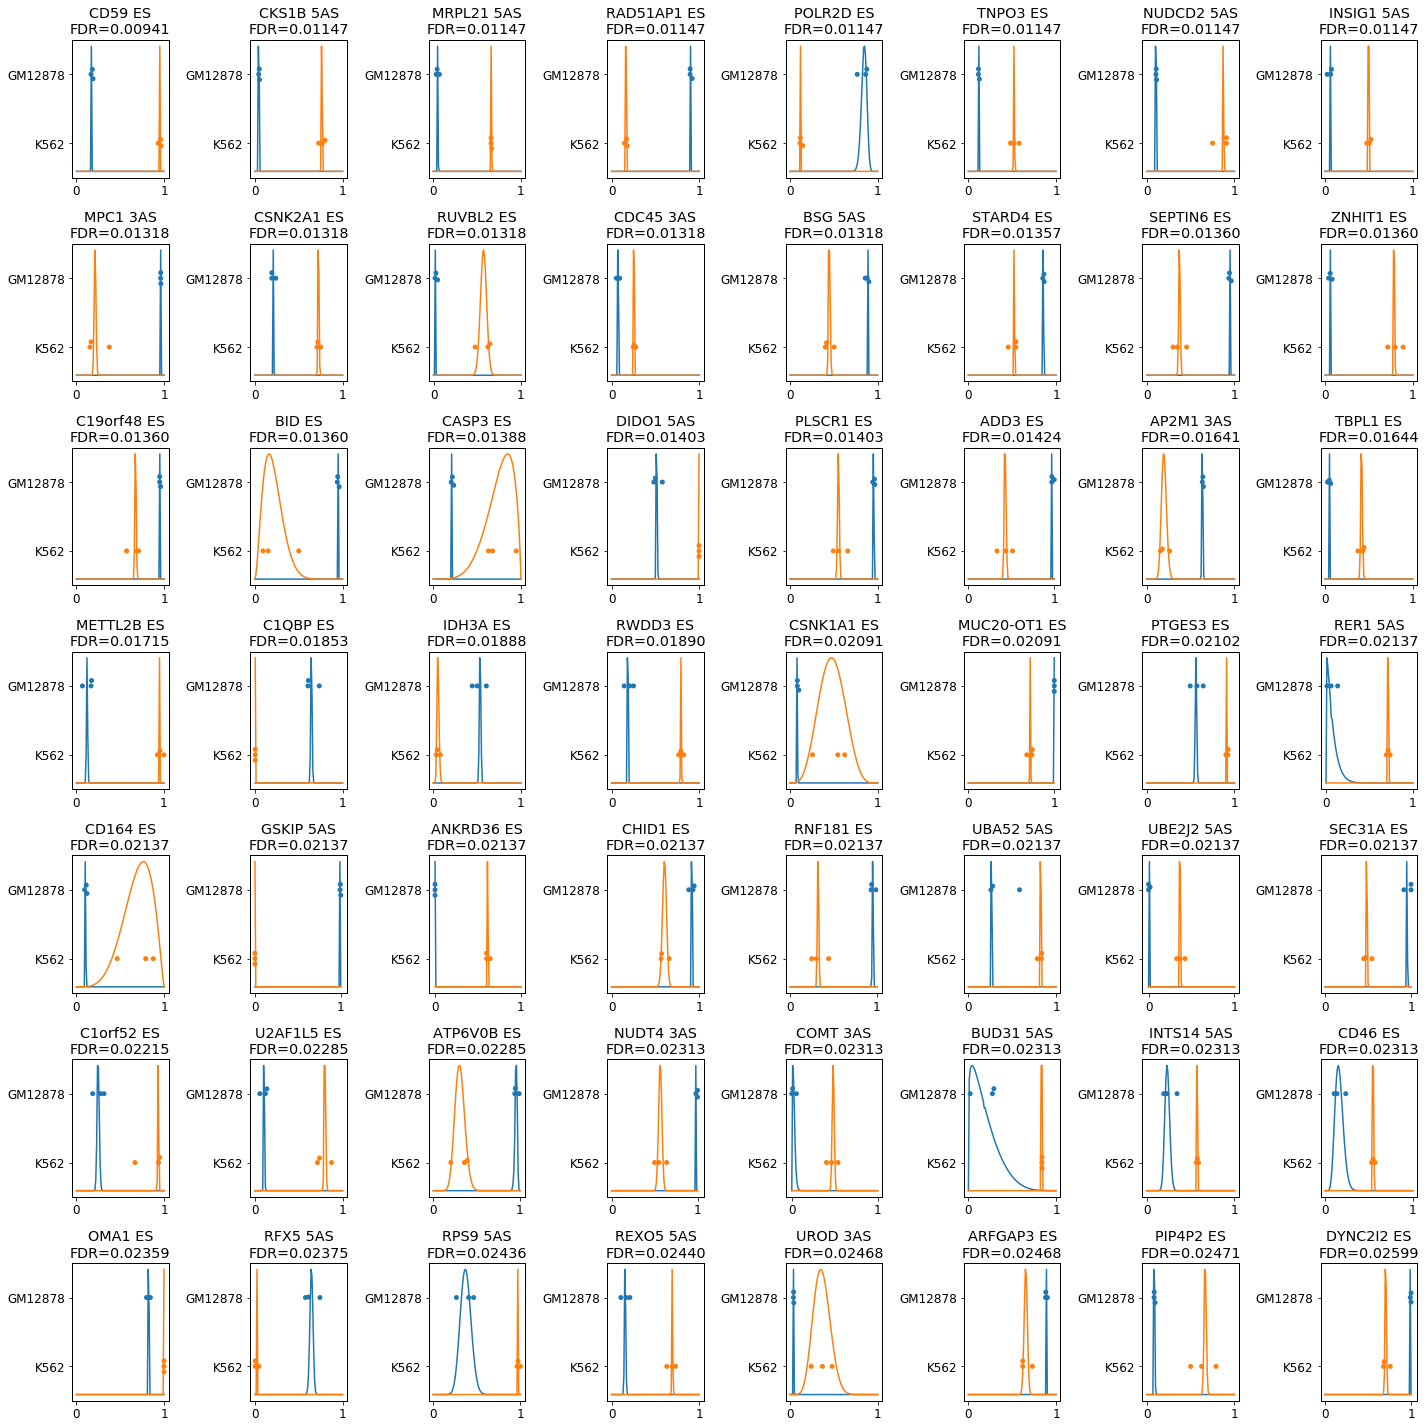

In [26]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,8),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

CD59 ES (known) FDR=9.41e-03: GM12878=17.7 vs K562=95.5 PSI


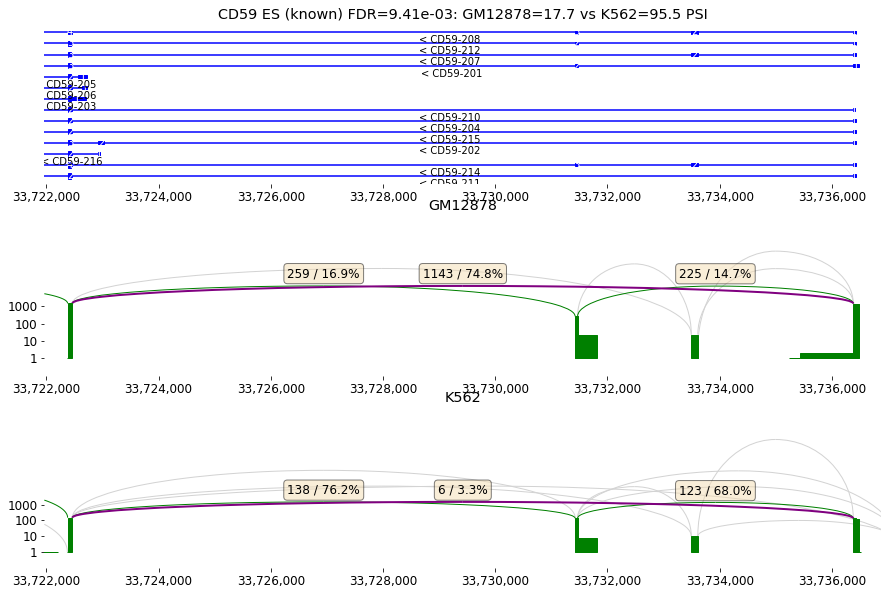

In [27]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[0]
plot_diff_example(row, isoseq, groups)

In [28]:
gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'GM12878':gr['GM12878']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs GM12878 (3) using betabinom_lr test
100%|██████████| 589580/589580 [19:34<00:00, 502.06it/s]  


1478 differential splice sites in 1122 genes for leukemia vs GM12878


index     gene             gene_id  chrom strand      start        end  \
5    1006    ACADM  ENSG00000117054.14   chr1      +   75724817   75732643   
10   8897   INTS14  ENSG00000138614.15  chr15      -   65607442   65611097   
11   8473    IDH3A  ENSG00000166411.14  chr15      +   78155275   78157547   
14  16405    DIDO1  ENSG00000101191.17  chr20      -   62914406   62926438   
18  24126  METTL2B  ENSG00000165055.16   chr7      +  128476875  128479157   
22   2137    PTPRC  ENSG00000081237.20   chr1      +  198692373  198703297   
24  15588  RNASEH1  ENSG00000171865.10   chr2      -    3556904    3558132   
34  20788   NUDCD2  ENSG00000170584.11   chr5      -  163457610  163459861   
37  15061  SLC20A1  ENSG00000144136.11   chr2      +  112652798  112657121   
48  23718   ZDHHC4  ENSG00000136247.15   chr7      +    6577498    6578565   

   splice_type  novel      padj  ...  HL-60_1_1_leukemia_in_cov  \
5           ES  False  0.008918  ...                        264   
10         5AS  False  0.010599  ...                        135   
11          ES  False  0.011121  ...                         16   
14         5AS   True  0.011419  ...                        174   
18          ES  False  0.011419  ...                        122   
22          ES  False  0.011589  ...                         67   
24         5AS   True  0.012305  ...                         14   
34         5AS   True  0.014510  ...                         67   
37          ES  False  0.014510  ...                         49   
48          ES  False  0.016662  ...                         98   

    HL-60_1_1_leukemia_total_cov  HL-60_2_1_leukemia_in_cov  \
5                            325                        206   
10                           224                        110   
11                           433                         28   
14                           174                        156   
18                           123                         67   
22                           297                         58   
24                            20                          5   
34                           127                         65   
37                           299                         42   
48                           160                         65   

    HL-60_2_1_leukemia_total_cov  GM12878_1_1_GM12878_in_cov  \
5                            256                         155   
10                           180                          19   
11                           352                           8   
14                           156                          29   
18                            68                           3   
22                           331                          58   
24                             7                           0   
34                           105                           9   
37                           226                           3   
48                           102                           8   

    GM12878_1_1_GM12878_total_cov  GM12878_1_1_b_GM12878_in_cov  \
5                             164                         802.0   
10                             55                          37.0   
11                             18                          43.0   
14                             50                          38.0   
18                             18                           5.0   
22                             63                         186.0   
24                              1                           0.0   
34                             83                          17.0   
37                            129                           7.0   
48                             15                           0.0   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
5                             836.0                      1104.0   
10                            161.0                        43.0   
11                             71.0                        49.0   
14

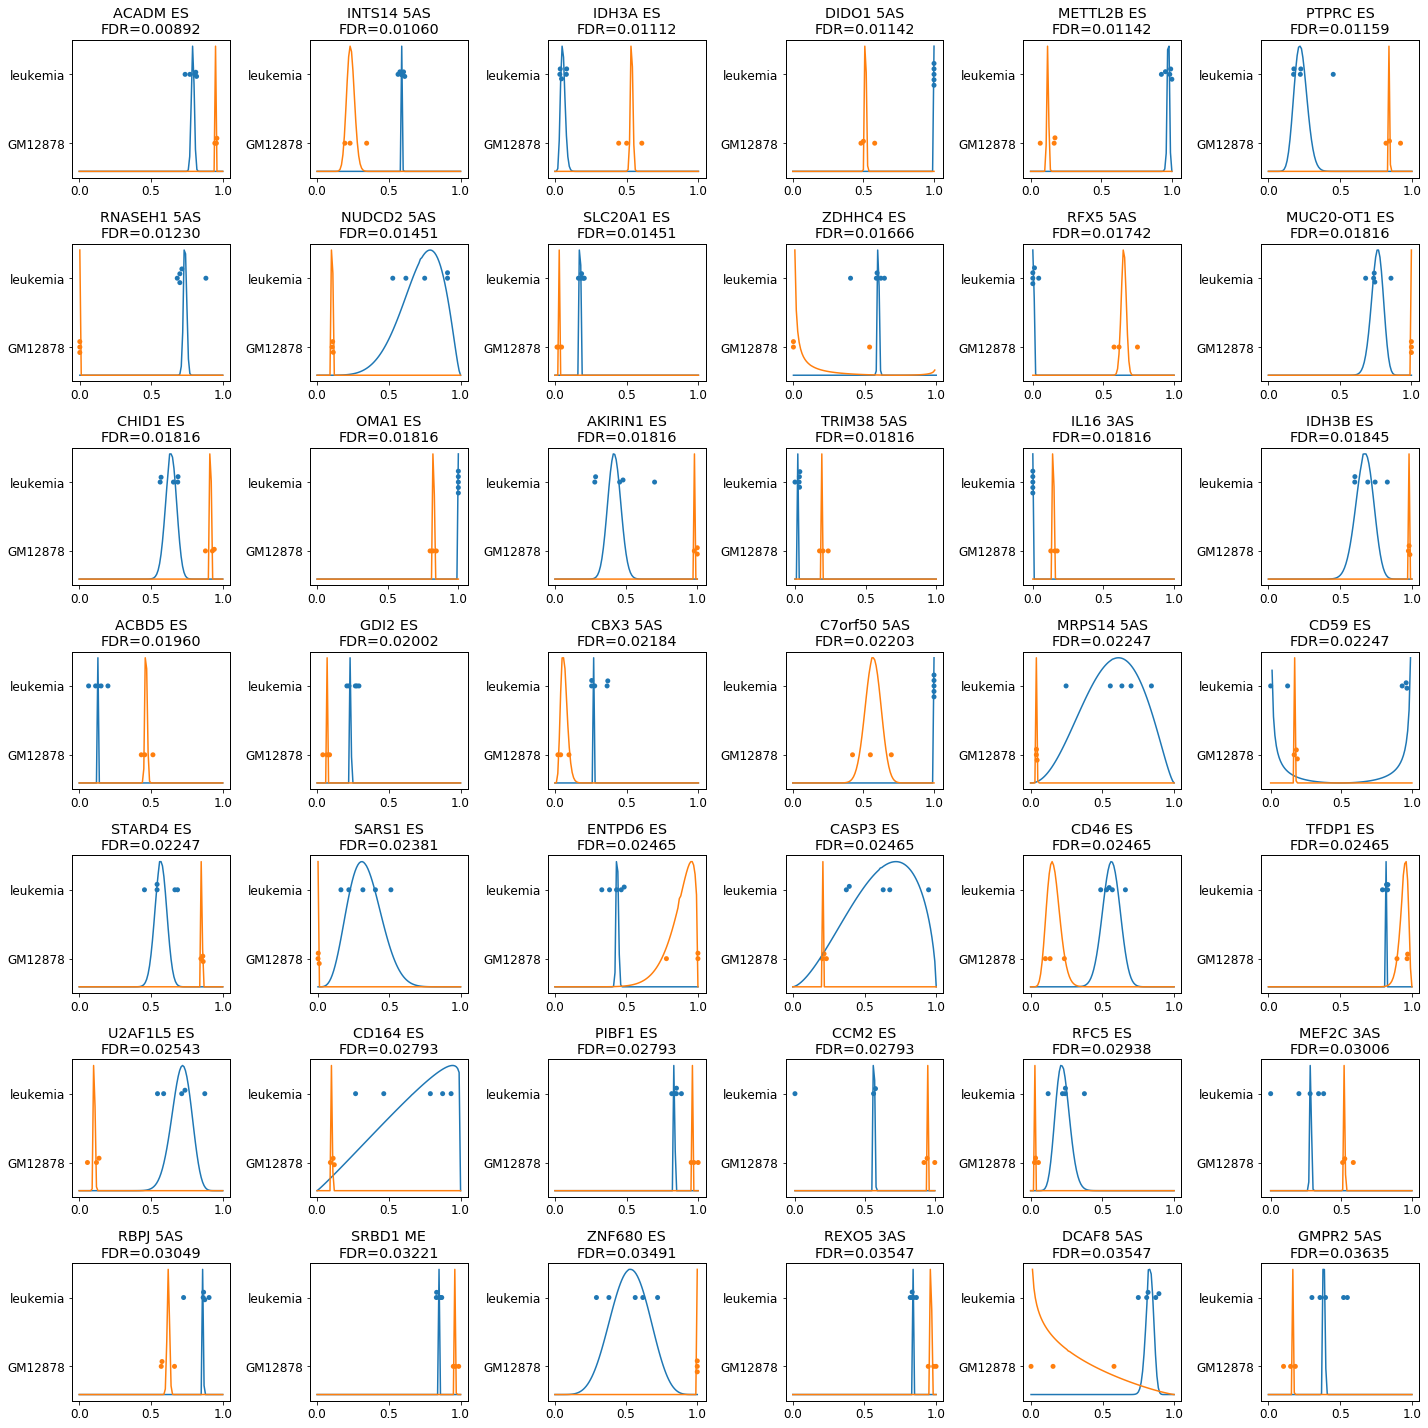

In [29]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

ACADM ES (known) FDR=8.92e-03: leukemia=79.1 vs GM12878=95.6 PSI


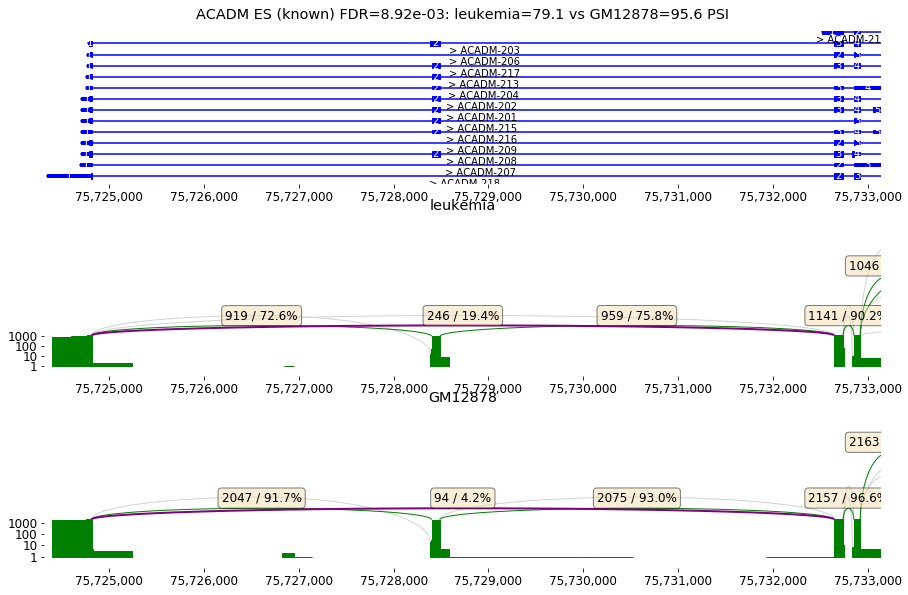

In [53]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[5]
plot_diff_example(row, isoseq, groups)

### Carcinoma cell lines
Carcinomas often feature mutations in RBM10 or deregulation of SRSF1, SRSF3 and SRSF6, each leading to specific splicing defects. 

In [31]:

diff_cmp='Panc1/progenitor cell of endocrine pancreas'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}


#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for Panc1 (1) vs progenitor cell of endocrine pancreas (2) using proportions test
  1%|          | 6423/589580 [00:00<00:11, 52104.62it/s]/home/lienhard/.local/lib/python3.7/site-packages/isotools/_transcriptome_stats.py:23: RuntimeWarning: invalid value encountered in long_scalars
  p1=[x[i]/n[i] for i in range(2)]
/home/lienhard/.local/lib/python3.7/site-packages/isotools/_transcriptome_stats.py:25: RuntimeWarning: divide by zero encountered in long_scalars
  z=abs(p1[0]-p1[1])/np.sqrt(p0*(1-p0)*(1/n[0]+1/n[1]))
100%|██████████| 589580/589580 [08:30<00:00, 1154.31it/s]


7650 differential splice sites in 3533 genes for Panc1 vs progenitor cell of endocrine pancreas


index     gene             gene_id  chrom strand      start        end  \
48    3377    RPLP0  ENSG00000089157.16  chr12      -  120200831  120201082   
73    5877   SNHG16  ENSG00000163597.15  chr17      +   76557857   76561287   
92   11984    CD164  ENSG00000135535.17   chr6      -  109369017  109376073   
112   2598     CD59  ENSG00000085063.17  chr11      -   33722463   33736381   
121  12398     CALU  ENSG00000128595.17   chr7      +  128748804  128758870   
122   7964     BZW1  ENSG00000082153.18   chr2      +  200811727  200813207   
171   3318     KRT8  ENSG00000170421.12  chr12      -   52900062   52900587   
174  10156    EXOC1  ENSG00000090989.18   chr4      +   55883928   55890222   
176   3438  SLC25A3  ENSG00000075415.13  chr12      +   98593740   98593978   
190   2908   PPP1CA  ENSG00000172531.16  chr11      -   67400919   67401727   

    splice_type  novel           padj  ...  \
48          3AS  False  1.319486e-149  ...   
73           ES  False  3.014849e-112  ...   
92           ES  False   7.917895e-97  ...   
112          ES  False   2.504424e-86  ...   
121          ME  False   8.147856e-82  ...   
122         5AS  False   1.519923e-81  ...   
171         3AS   True   1.676812e-60  ...   
174          ES  False   6.819701e-60  ...   
176         3AS  False   2.484497e-59  ...   
190          ES  False   4.382262e-54  ...   

     progenitor cell of endocrine pancreas_PSI  \
48                                    0.059271   
73                                    0.086667   
92                                    0.892730   
112                                   0.179406   
121                                   0.822660   
122                                   0.010152   
171                                   0.978887   
174                                   0.959627   
176                                   0.256329   
190                                   0.958824   

     progenitor cell of endocrine pancreas_disp  total_PSI  total_disp  \
48                                            0   0.108604           0   
73                                            0   0.289373           0   
92                                            0   0.806075           0   
112                                           0   0.288462           0   
121                                           0   0.744892           0   
122                                           0   0.551724           0   
171                                           0   0.878487           0   
174                                           0   0.833333           0   
176                                           0   0.566494           0   
190                                           0   0.794989           0   

     Panc1_1_1_Panc1_in_cov  Panc1_1_1_Panc1_total_cov  \
48                      114                        153   
73                      174                        181   
92                       28                        156   
112                     146                        150   
121                      34                        194   
122                     286                        325   
171                     397                        571   
174                       1                         50   
176                     247                        263   
190                      23                         99   

     progenitor_cell_of_endocrine_pancreas_2_1_progenitor cell of endocrine pancreas_in_cov  \
48                                                  52                                        
73                                                  19                                        
92                                                 995                                        
112                                                 77                                        
121                                               1117                                        
122                                                  

SNHG16 ES (known) FDR=3.01e-112: Panc1=96.1 vs progenitor cell of endocrine pancreas=8.7 PSI


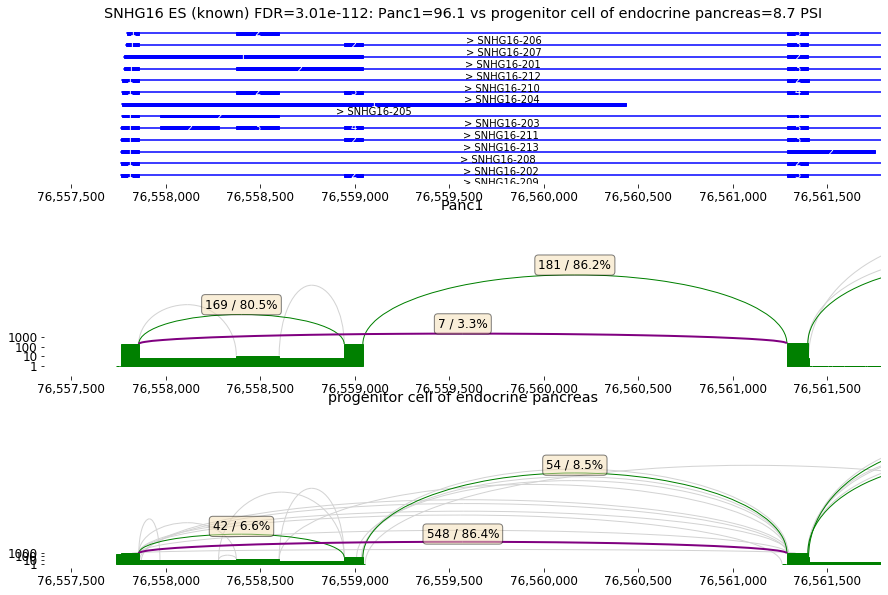

In [56]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[73]
plot_diff_example(row, isoseq, groups)

In [33]:
#all carcinoma vs normal endoderm
karyotype=isoseq.groups('karyotype')
lineage=isoseq.groups('lineage')
cell=isoseq.groups('cell')

groups={'carcinoma':[sa for sa in karyotype['cancer'] if sa in cell['epithelial cell']], 
        'normal endoderm':[sa for sa in karyotype['normal'] if sa in lineage['endoderm']]}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for carcinoma (5) vs normal endoderm (9) using betabinom_lr test
100%|██████████| 589580/589580 [21:43<00:00, 452.21it/s]  


7515 differential splice sites in 4432 genes for carcinoma vs normal endoderm


index    gene             gene_id  chrom strand      start        end  \
1   22406    NHP2   ENSG00000145912.9   chr5      -  178149838  178153490   
4    1140   RPL11  ENSG00000142676.14   chr1      +   23691829   23692611   
20  19446  CHMP2B  ENSG00000083937.10   chr3      +   87227556   87240698   
23   4061   BANF1   ENSG00000175334.8  chr11      +   66002513   66003234   
40  22544    BTF3  ENSG00000145741.16   chr5      +   73498558   73499133   
41  13753  PWWP3A  ENSG00000160953.16  chr19      +    1358464    1360135   
64  13188   NARS1  ENSG00000134440.12  chr18      -   57620648   57621707   
65  26121   THEM6   ENSG00000130193.8   chr8      +  142727700  142735325   
78  10732    CBFB  ENSG00000067955.15  chr16      +   67029813   67066681   
81  19991  NDUFB5  ENSG00000136521.13   chr3      +  179604939  179616982   

   splice_type  novel      padj  ...  \
1           ES  False  0.000012  ...   
4          3AS  False  0.000043  ...   
20          ES  False  0.000074  ...   
23         5AS  False  0.000094  ...   
40         5AS  False  0.000175  ...   
41          ES  False  0.000176  ...   
64         3AS  False  0.000384  ...   
65         5AS   True  0.000419  ...   
78          ES  False  0.000556  ...   
81          ES  False  0.000562  ...   

    type_B_pancreatic_cell_2_1_normal endoderm_in_cov  \
1                                                  49   
4                                                 933   
20                                                  3   
23                                                 40   
40                                                  5   
41                                                  0   
64                                                 47   
65                                                 16   
78                                                 34   
81                                                 98   

    type_B_pancreatic_cell_2_1_normal endoderm_total_cov  \
1                                                  50      
4                                                1065      
20                                                 70      
23                                                 41      
40                                                519      
41                                                  2      
64                                                223      
65                                                 16      
78                                                 35      
81                                                107      

    type_B_pancreatic_cell_1_1_normal endoderm_in_cov  \
1                                                  45   
4                                                1065   
20                                                  8   
23                                                 26   
40                                                  2   
41                                                  1   
64                                                 50   
65                                                  6   
78                                                  8   
81                                                175   

    type_B_pancreatic_cell_1_1_normal endoderm_total_cov  \
1                                                  46      
4                                                1200      
20                                                111      
23                                                 35      
40                                                730      
41                                                  3      
64                                                272      
65                                                  6      
78                                                  8      
81                                                189      

    lower_lobe_of_left_lung_1_1_b_normal endoderm_in_cov  \
1                                                  43      
4                

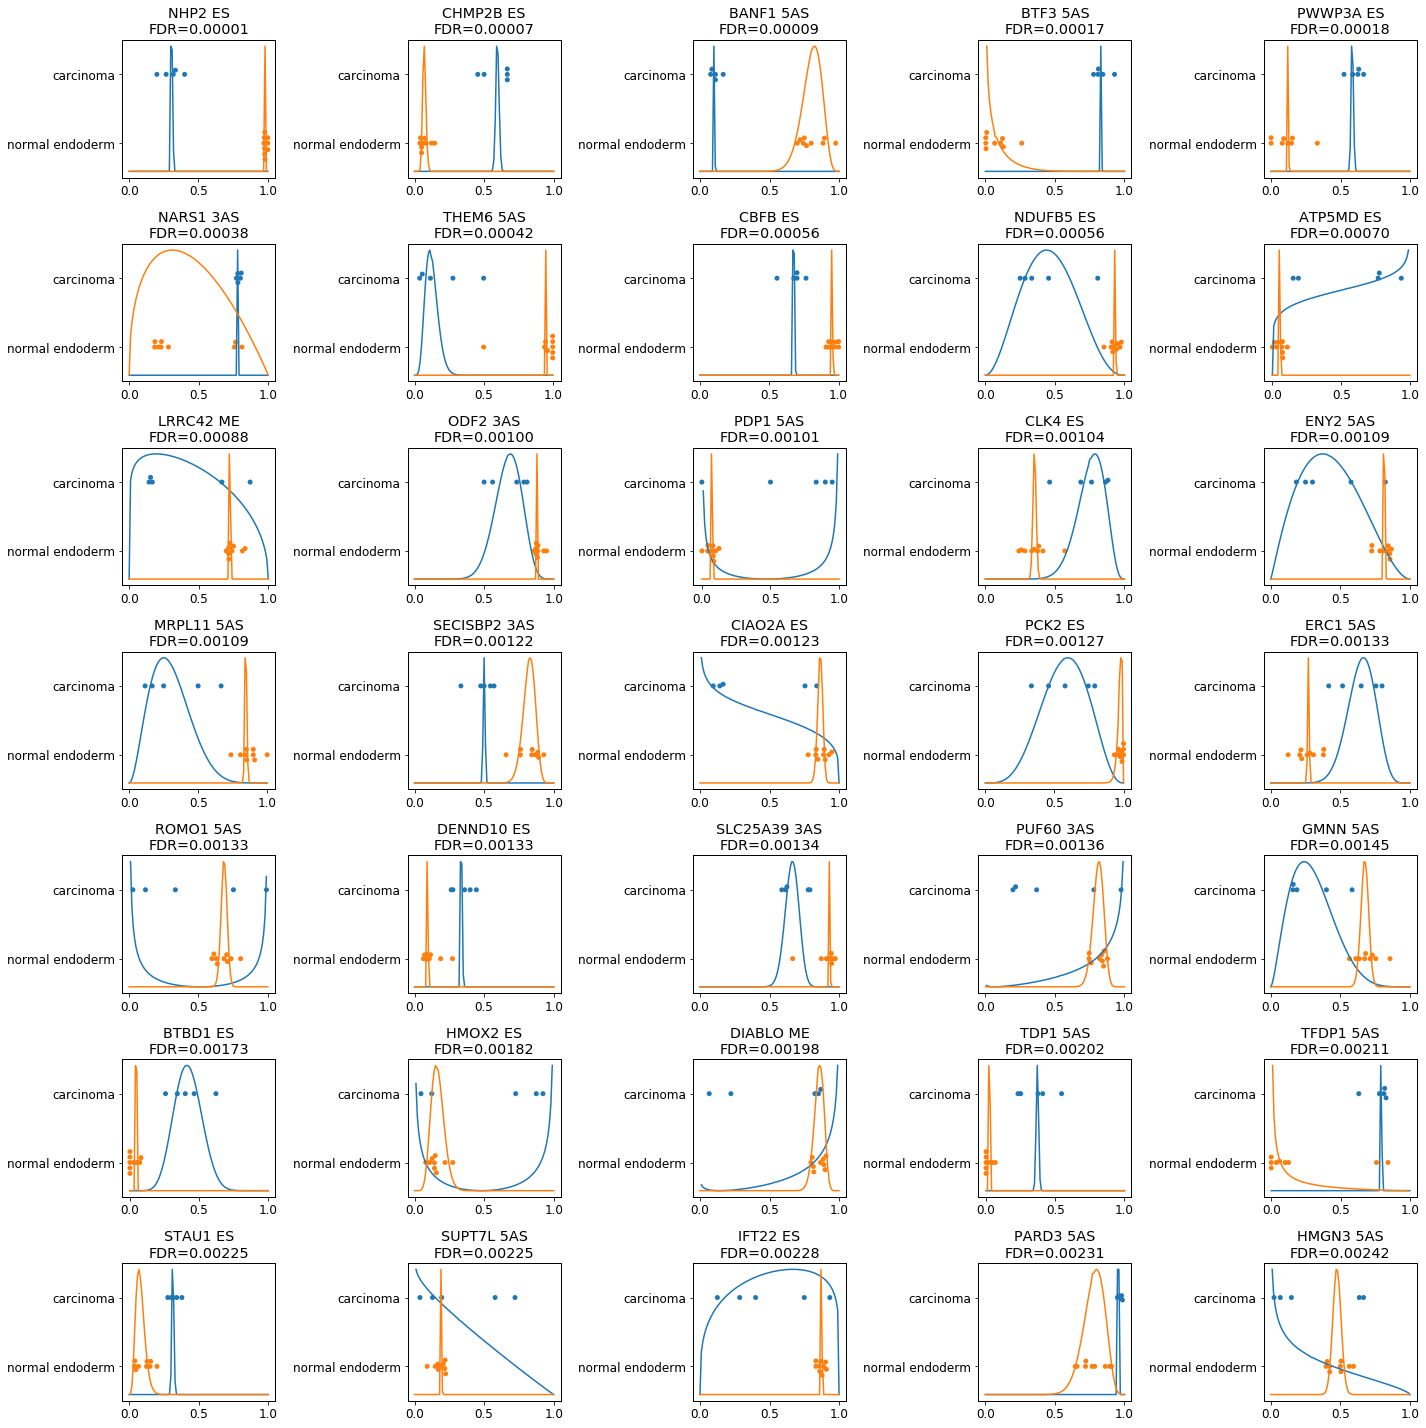

In [34]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,5),min_support=2, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

NHP2 ES (known) FDR=1.15e-05: carcinoma=30.9 vs normal endoderm=98.2 PSI


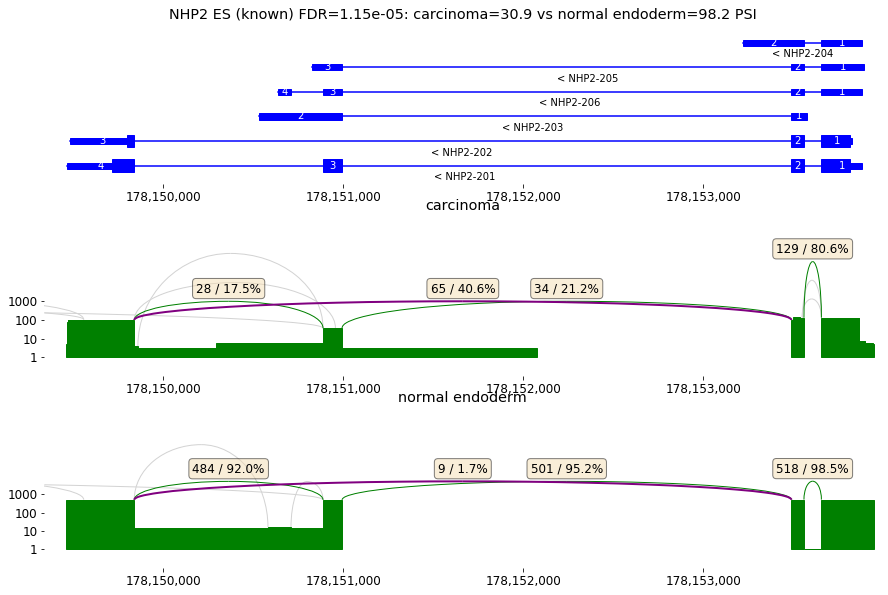

In [59]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[1]
plot_diff_example(row, isoseq, groups)

In [36]:
#differential splicing all leukemia vs carcinoma

gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'carcinoma':gr['Panc1']+gr['HCT116']+gr['HepG2']+gr['PC-3']+gr['MCF-7']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs carcinoma (5) using betabinom_lr test
100%|██████████| 589580/589580 [22:15<00:00, 441.35it/s]  


2014 differential splice sites in 1507 genes for leukemia vs carcinoma


index     gene             gene_id  chrom strand      start        end  \
0    6242   NAP1L4  ENSG00000205531.13  chr11      -    2945646    2951258   
2   32538  HNRNPH2   ENSG00000126945.9   chrX      +  101408307  101411935   
9   26111     BTF3  ENSG00000145741.16   chr5      +   73498558   73499133   
18  27686    HMGA1  ENSG00000137309.20   chr6      +   34240882   34242711   
19  19332     AAMP  ENSG00000127837.10   chr2      -  218269534  218269965   
23  26441    PNISR  ENSG00000132424.16   chr6      -   99402710   99404602   
25   9324     INF2  ENSG00000203485.14  chr14      +  104714856  104718794   
37  30075    SDCBP  ENSG00000137575.12   chr8      +   58572314   58575902   
39  15335    NARS1  ENSG00000134440.12  chr18      -   57620648   57621707   
48  22819   CHMP2B  ENSG00000083937.10   chr3      +   87227556   87240698   

   splice_type  novel      padj  ...  Panc1_1_1_carcinoma_in_cov  \
0           ES  False  0.002026  ...                          54   
2          5AS   True  0.002290  ...                         368   
9          5AS  False  0.005500  ...                          39   
18         5AS  False  0.012175  ...                          41   
19         3AS  False  0.012175  ...                          33   
23         5AS  False  0.012916  ...                           8   
25          ES  False  0.012916  ...                          73   
37         3AS  False  0.014178  ...                          17   
39         3AS  False  0.014209  ...                         224   
48          ES  False  0.015936  ...                           6   

    Panc1_1_1_carcinoma_total_cov  HCT116_1_1_carcinoma_in_cov  \
0                             265                           85   
2                             406                            1   
9                              42                           51   
18                            113                          266   
19                             49                           36   
23                             15                            3   
25                             78                           29   
37                             97                           16   
39                            278                          313   
48                              9                            8   

    HCT116_1_1_carcinoma_total_cov  HepG2_1_1_carcinoma_in_cov  \
0                              394                          81   
2                               22                           1   
9                               63                          56   
18                             597                          43   
19                              61                          11   
23                               4                           4   
25                              32                          73   
37                              81                         113   
39                             406                         570   
48                              12                           3   

    HepG2_1_1_carcinoma_total_cov  PC-3_1_1_carcinoma_in_cov  \
0                             459                         44   
2                              39                          1   
9                              72                         13   
18                             95                         97   
19                             88                         37   
23                              5                          3   
25                             91                         28   
37                            146                         65   
39                            730                        412   
48                              6                          5   

    PC-3_1_1_carcinoma_total_cov  MCF-7_1_1_carcinoma_in_cov  \
0                            298                          47   
2                             45                           1   
9                             16             

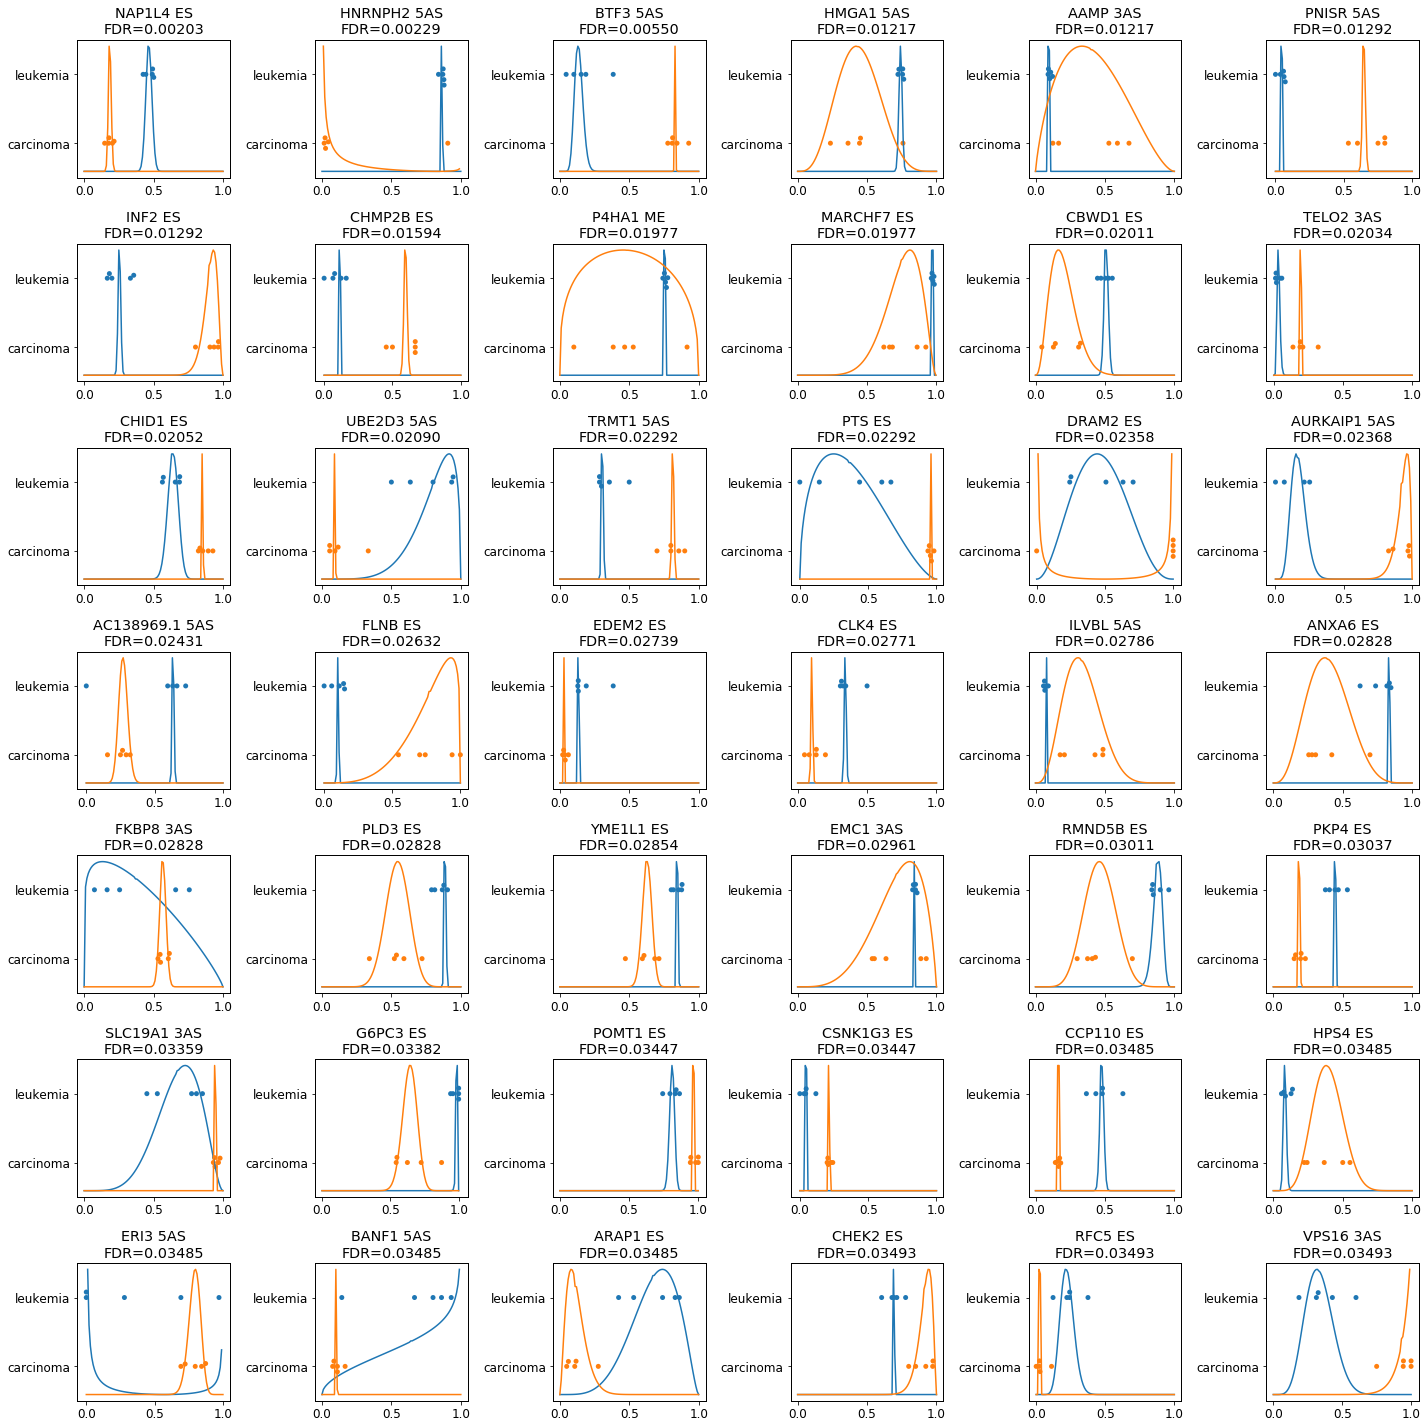

In [37]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=3, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

NAP1L4 ES (known) FDR=2.03e-03: leukemia=46.6 vs carcinoma=18.5 PSI


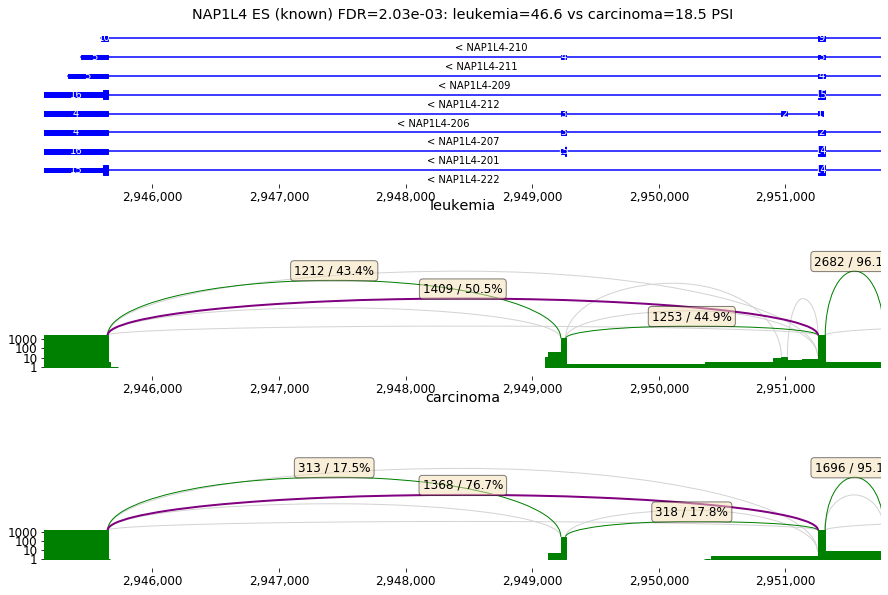

In [38]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[0]
plot_diff_example(row, isoseq, groups)